In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import itertools
# import NOTEARS
import nt_linear as nt
from dag_generator import DAGGenerator
from sklearn.preprocessing import scale
import scipy
from matplotlib import animation
import seaborn as sns

# Varsortability
This notebook implements the measure of _varsortability_ proposed in [this paper](https://arxiv.org/pdf/2102.13647.pdf). The main essence of the paper is that, if we want to build up artifical datasets for e.g. causal discovery benchmarks, we must be careful. This is because continouos optimization approaches on CD could exploit that, if wrongly done, the variance of the data corresponding to a node in the graph increases along the causal order. I.e. if there is a graph $X \rightarrow Y \rightarrow Z$, one often obtains that $Var(X) < Var(Y) < Var(Z)$.

Varsortability measures the agreement between the order of increasing marginal variance and the causal order, i.e.:

\begin{equation}
v = \frac{\sum_{k=1}^{d-1} \sum_{i \rightarrow j \in E^k} inc(Var(X_i), Var(X_j))}{\sum_{k=1}^{d-1} \sum_{i \rightarrow j \in E^k} 1}
\end{equation}
In the above equation $E$ is the adjacency matrix and $inc$ is defined as follows:
\begin{equation*}
inc(a, b) := 
\begin{cases}
   1 &\text{if } a < b \\
   \frac{1}{2} &\text{if } a = b  \\
   0 &\text{if} a > b \end{cases}
\end{equation*}

# Count Walks using Adjacency Matrix
In the above equation the authors make use of the power of the adjacency matrix $E$. This section briefly explains why this really works and how one could count the walks from a node $i$ to a node $j$ in a graph using its adjacency matrix. You can skip this if you're not interested in this.

Since causal datasets are generated using DAGs, this will only focus on the case where the adjacency represents a DAG. For example, consider the following adjacency matrix:
\begin{equation}
A = 
\begin{pmatrix}
0 & 1 & 1 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1 \\
0 & 0 & 0 & 0 & 0 \end{pmatrix}
\end{equation}

The corresponding graph is shown below.

Now, let's count all walks of lengths 1 from some node $i$ to some node $j$. Obviously, there is only a walk possible if $i$ and $j$ are adjacent, i.e. if $A_{i, j} = 1$. Counting all walks of lengths 2 can be done using $A^2$. To see this, let's consider the walk $X_1 \rightarrow X_3 \rightarrow X_4$. Why does $A^2$ yield $(A^2)_{1, 4} = 1$? To obtain the value of $(A^2)_{1, 4}$ the rules of matrix-multiplication tell us that we have to compute $A_{1, :} \times A_{:, 4}$ where $A_{i, :}$ is the $i$-th row and $A_{:, j}$ is the $j$-th column. Since there is an edge $X_1 \rightarrow X_3$, the adjacency matrix tells us $A_{1, 3} = 1$. The same holds for $X_3 \rightarrow X_4$ where we obtain $A_{3, 4} = 1$ in $A$. Now, while performing matrix multiplication, row $A_{1, :}$ will produce values $>0$ for each column where either row 2 or row 3 is not 0. This is because  $A_{1, 3} = 1$ and  $A_{1, 2} = 1$. Due to the edge $X_3 \rightarrow X_4$  $A_{3, 4} = 1$ holds, thus we have a match between the 3rd column of row 1 and the 3rd row of column 3. Since the rest of column 4 has value 0, no other match is obtained, resulting in $(A^2){1, 4} = 1$. If there were an edge $X_2 \rightarrow X_4$, we would have obtained another match between the second column of row 1 and the second row of column 4, which would have yield $(A^2){1, 4} = 2$, i.e. that tehre are two possible walks from 1 to 4.

Since $A^k$ "memorizes" the number all possible walks of length $k$ for each $i, j \in V(G)$, $A^{k+1}$ will yield the number of all possible walks between a node $i$ and a node $l$ if there exists $X_j \rightarrow X_l$. This can be verfied applying the same reasoning from above.

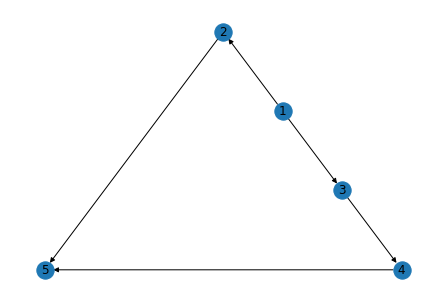

In [2]:
adj = np.array([
    [0, 1, 1, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0]
])
# create df of adjacency to adjust labels
adj_df = pd.DataFrame(adj, columns=list(range(1, 6)), index=list(range(1, 6)))
G = nx.convert_matrix.from_pandas_adjacency(adj_df, create_using=nx.DiGraph)
nx.draw_planar(G, with_labels=True)

## Implementation

In [2]:
def inc(a, b):
    if a < b:
        return 1
    if a == b:
        return 0.5
    else:
        return 0

In [3]:
def varsortability_step(adj, data):
    # compute demoniator
    # replace all numbers greater 0 with 1 to make computation of all existing edges/walks easier
    walk_adj = adj.copy()
    walk_adj[walk_adj != 0] = 1
    walk_number = walk_adj.sum()

    # compute sum of number of increasing marginal variances
    increasing_variances = 0
    walk_indices = np.argwhere(walk_adj == 1)
    for i, j in walk_indices:
        data_i, data_j = data[:, i], data[:, j]
        increasing_variances += inc(data_i.var(), data_j.var())
    
    return walk_number, increasing_variances

In [4]:
def varsortability(adj, data):
    # check that adj is quadratic and that data has dimensions m x n where n is the number of nodes in the graph
    assert adj.shape[0] == adj.shape[1]
    assert adj.shape[0] == data.shape[1]

    increasing_vars, walk_numbers = [], []
    # iterate from 1 to d-1
    for i in range(1, adj.shape[0]):
        mat_pow = np.linalg.matrix_power(adj, i)
        wn, iv = varsortability_step(mat_pow, data)
        increasing_vars.append(iv)
        walk_numbers.append(wn)

    return np.sum(increasing_vars) / np.sum(walk_numbers)

## Original implementation used in paper
The implementation below was given by the authors of the paper described above. A little more elegant but harder to understand...

In [5]:
def varsortability_orig(X, W):
    """ Takes n x d data and a d x d adjaceny matrix,
    where the i,j-th entry corresponds to the edge weight for i->j,
    and returns a value indicating how well the variance order
    reflects the causal order. """
    E = W != 0
    Ek = E.copy()
    var = np.var(X, axis=0, keepdims=True)
    tol = var.min() * 1e-9

    n_paths = 0
    n_correctly_ordered_paths = 0

    for k in range(E.shape[0] - 1):
        n_paths += Ek.sum()
        n_correctly_ordered_paths += (Ek * var / var.T > 1 + tol).sum()
        Ek = Ek.dot(E)

    return n_correctly_ordered_paths / n_paths

In [7]:
metadata = pd.read_csv('./data/metadata.csv', index_col=0)

In [7]:
metadata_lin_gauss = metadata[(metadata['nodes'] < 20) & (metadata['f'] == 'linear') & (metadata['sample_noise'] == 'gaussian') & (metadata['sample_parent'] == 'gaussian') & (metadata['common_cause_to_confounder_fraction'] == 0)]

In [71]:
graph_files = ['./graphs/graph_5_10.csv', './graphs/graph_10_20.csv', './graphs/graph_20_40.csv']
data_files = ['./data/01abfd41-8a7d-4559-b959-9fe3a4157602.csv', './data/ab79a026-b7e3-47f3-8b6b-7b3cceed68d4.csv', './data/63221cbe-4457-4471-be32-4196a93e946c.csv']
# try the same for linear-uniform case instead of linear-gaussian
# data_files = ['./data/3184865e-e92a-4d71-a793-50705d67a394.csv', './data/6615bc0b-a890-470a-9f0d-98ffc70deefe.csv', './data/61267615-3116-4a11-97bd-950b368d26ed.csv']

In [72]:
vars_data = {}
for i, node_num in zip(range(0, len(graph_files)), [5, 10, 20]):
    graph = pd.read_csv(graph_files[i], index_col=0)
    data = pd.read_csv(data_files[i], index_col=0)
    vars_data[node_num] = (graph, data)

In [73]:
for key, tpl in vars_data.items():
    graph, data = tpl
    print(varsortability(graph.to_numpy(), data.to_numpy()))
    # print(varsortability_orig(data.to_numpy(), graph.to_numpy()))

1.0
0.9888888888888889
0.9937106918238994


# Possible solutions to overcome this problem
The problem is that, by sampling random parameters downstream the causal order, the variance gets higher and higher. Probably this is just a problem of finding appropriate parameters based on the previously chosen parameters/resulting variance. Since the variance is accumulated downstream, it's probably enough to shrink the set of possible parameters in each sample step.

The problem described in the paper should be generalizable on all random variables $X, Y \sim V(\mu, \sigma)$ such that $Z = X + Y \sim V(\mu', \sigma')$ where $V$ is some distribution and $\sigma' > \sigma$ holds. Since this is the case for a Gaussian distributed RV, the result is not surprising.

One possible solution could be to do the following:
Given two RVs $X, Y \sim \mathcal{N}(\mu, \sigma)$ compute the RV $Z$ by $Z = \frac{X + Y}{2}$ since then $Z \sim \mathcal{N}(\frac{2 \mu}{2}, \frac{2 \mu}{2}) = \mathcal{N}(\mu, \sigma)$. However this solution would lead to $n$ random variables having the exact same distribution. Maybe a more sophisticated method must be used, s.t. varsortability converges to $\frac{1}{2}$ and we allow for different distributions. This means one has to memorize the parameters used to adapt distributions coming later in the causal chain.

In [8]:
def build_causal_chain(chain_len=5):
    # this builds an adjacency representing a chain
    # in a chain all entries above the diagonal are 1, the rest is 0
    adj = np.zeros((chain_len, chain_len))
    np.fill_diagonal(adj, 1)
    adj = np.roll(adj, 1)
    adj[0,0] = 0
    data = []
    for i, j in zip(range(0, chain_len), range(1, chain_len + 1)):
        if i == 0:
            X = np.random.normal(0, 1, 1000)
            data.append(X)
        else:
            W = data[i - 1]
            X = (W + np.random.normal(0, 1, 1000)) / np.sqrt(2) # sqrt(2) because variance is 1 and (sqrt(1 + 1)) = sqrt(2)
            data.append(X)
    return adj, np.array(data).T

In [9]:
cadj, cdata = build_causal_chain(6)

In [115]:
varsortability_scores = []
sizes = []
for _ in range(0, 1000):
    size = np.random.randint(3, 50)
    cadj, cdata = build_causal_chain(size)
    v = varsortability(cadj, cdata)
    sizes.append(size)
    varsortability_scores.append(v)

0.4968572028110551
0.14284519587560718


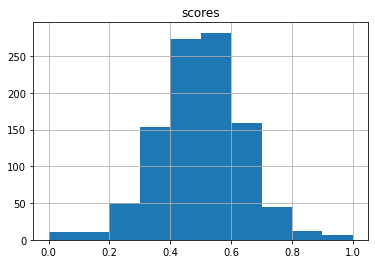

In [121]:
varsortability_scores = np.array(varsortability_scores)
vars_scores_df = pd.DataFrame.from_dict({'scores': varsortability_scores, 'size': sizes})
vars_scores_df.hist('scores')
print(vars_scores_df['scores'].mean())
print(vars_scores_df['scores'].std())

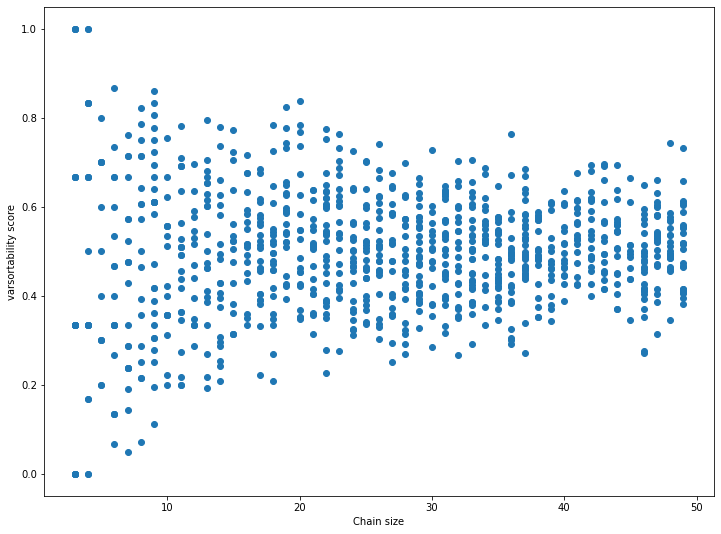

In [120]:
fig = plt.figure(figsize=(12, 9))
plt.scatter(vars_scores_df['size'], vars_scores_df['scores'])
plt.xlabel('Chain size')
plt.ylabel('varsortability score')
plt.show()

## Intermediate result
Yes, by scaling we can lower the varsortability score. However, there is a pretty high variance across different trials. In some trials we get $v=0.3$, in some trials $v=0.7$ and in others $v=0.5$

In [10]:
# build simple SCM
n = 1000
X1 = np.random.normal(0, 1, n)
X2 = (X1 + np.random.normal(0, 1, n)) / np.sqrt(2)
X3 = (X2 + np.random.normal(0, 1, n)) / np.sqrt(2)

In [11]:
print(X1.var())
print(X2.var())
print(X3.var())

1.068795296610087
1.0579462052963238
1.0041991152754013


# Varsortability on Energy System Data
Now, that we have confirmed the claims made by the varortability-paper for our artificial dataset, what about (more) realistic data? Does it also have this varortability-property which can be exploited by algorithms like NOTEARS? If we can confirm that such patterns also exist in real-world data, this shouldn't be a problem and such patterns can be used by CD algorithms to improve their performance. If real-world data does not show such a consistent pattern, we have to find ways to artificially generate datasets which do not yield patterns like varsortability in order to allow for useful benchmarks. Moreover continuous optimization algorithms like NOTEARS should be studied more in depth in order to understand if these methods can be "made causal".

In [9]:
gold_standard = pd.read_csv('./repos/MasterThesis/notebooks/algorithm_comparisons/causal_discovery_on_energy_data/gold_standard.csv', index_col=0)
gold_standard

CostPV  CostBat  CostBuy  Demand  CapPV  CapBat  OwnGen  TOTEX  CAPEX
CostPV      0.0      0.0      0.0     0.0    1.0     0.0     0.0    0.0    1.0
CostBat     0.0      0.0      0.0     0.0    0.0     1.0     0.0    0.0    1.0
CostBuy     0.0      0.0      0.0     0.0    1.0     0.0     0.0    1.0    0.0
Demand      0.0      0.0      0.0     0.0    1.0     1.0     1.0    1.0    0.0
CapPV       0.0      0.0      0.0     0.0    0.0     1.0     1.0    0.0    1.0
CapBat      0.0      0.0      0.0     0.0    1.0     0.0     0.0    0.0    1.0
OwnGen      0.0      0.0      0.0     0.0    0.0     0.0     0.0    0.0    0.0
TOTEX       0.0      0.0      0.0     0.0    0.0     0.0     0.0    0.0    0.0
CAPEX       0.0      0.0      0.0     0.0    0.0     0.0     0.0    1.0    0.0

In [10]:
data = pd.read_csv('./repos/MasterThesis/notebooks/data_generation/energy_data/data_obs_gaussian.csv', index_col=0)
data

CostPV     CostBat   CostBuy       Demand     CapPV    CapBat  \
0    1016.023980  297.948947  0.258562  2438.824896  0.771115  1.269610   
1     744.923275  292.878715  0.220945  5572.462936  1.937866  2.668660   
2     299.600309  338.325644  0.324518  5016.397389  6.659310  7.475734   
3    1045.626516  308.114449  0.302694  3503.411514  1.325290  2.352988   
4    1064.411392  257.375945  0.309753  2693.317462  1.117380  2.263249   
..           ...         ...       ...          ...       ...       ...   
120  1631.488751  347.950332  0.150885  4664.487761  0.141849  0.054156   
121  1431.026231  281.990796  0.290964  2563.922770  0.663529  1.284926   
122   764.877581  365.953729  0.344653  4943.749696  2.773992  4.211524   
123  1377.707150  251.807713  0.239463  3020.905698  0.654491  1.242732   
124   780.695145  384.409945  0.350211  4656.344825  2.575513  3.880651   

       OwnGen        TOTEX       CAPEX  
0    0.308060   552.504336  116.175045  
1    0.314317  1066.734384  222.515507  
2    0.587343  1124.206550  452.436412  
3    0.346910   903.651282  211.074766  
4    0.374912   698.674493  177.185788  
..        ...          ...         ...  
120  0.043789   698.010735   25.026915  
121  0.280403   668.012052  131.186423  
122  0.416782  1360.031847  366.298703  
123  0.248963   664.759485  121.462581  
124  0.413029  1307.421752  350.245102  

[1000 rows x 9 columns]

In [11]:
vastblty = varsortability(gold_standard.to_numpy(), data.to_numpy())
vastblty

0.46511627906976744

## Result
We see a varsortability score of 0.46 which is near 0.5. However, the data comes from an LP which is fed with data coming from a gaussian distribution. Since LPs are fully determinisitc, no noise is added in the data generation (except the input variables). Thus the LP does not respect the assumptions made in SCMs. Nevertheless this result shows that in "real-world" datasets the varsortability is not high necessarily. The next question is: Why is this?

# Attacking NOTEARS
Considering the data above, one obtains that the variables all have different scales. This is kind of natural since different variables are often measured in different units. For example, costs are measured in some currency (e.g. Euros), power demand is measured in Watts or Kilowatts and so on. However, the scale of the variables is independent of the causal mechanism producing the variable. For example, it shouldn't make a difference if we deploy the same energy system in Germany, Japan, Pakistan or the U.S. The causal influence of the costs on other variables should be the same in all cases, independent if we measure the costs in Euros, Yen, Pakistany Rupien or US-Dollar. This is essentially the point the abovementioned paper makes.

Another observation is that NOTEARS implicitely assumes faithfulness (i.e. all independencies found in the distribution are found in the causal graph producing this distribution). _Check this!!!_ 
One hypothesis is that, if the data is scaled appropriately, varsortability can be exploited to find the true causal graph with NOTEARS although faithfulness does not hold (as it is the case in distirbutions generated by LPs).

This can be generalized: Not only the measurement-unit or -scale enables NOTEARS to learn the true causal graph by exploiting varsortability, but the other way around is also possible: Combining the two observations from above, we should be able to scale the variables in the data such that we can fool NOTEARS. This would result in the fact that we can dictate NOTEARS what to predict by just scaling the data appropriately, i.e. we can choose the graph beforehand.

## Attacking Chains
First the easiest case is verified. A chain is a graph of the form $X_1 \rightarrow X_2 \rightarrow ... X_n$. In such a case the goal is to either destroy the chain, i.e. pertubating the data s.t. the estimation of NOTEARS is of the form $X_1 \rightarrow X_2 \rightarrow ... X_i \leftarrow X_j \rightarrow ... X_n$ or to change two or more variables in the chain, i.e. make NOTEARS finding a graph of the form $X_1 \rightarrow X_2 \rightarrow ... X_i \rightarrow X_j \rightarrow ... X_n$ where $i < j$.

In [61]:
# build causal chain and data
chain, cdata = build_causal_chain(4)

In [62]:
varsortability(chain, cdata)

0.5

In [63]:
gold_standard = nx.convert_matrix.from_numpy_array(chain, create_using=nx.DiGraph)
nt_pred = nt.notears_linear(cdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)

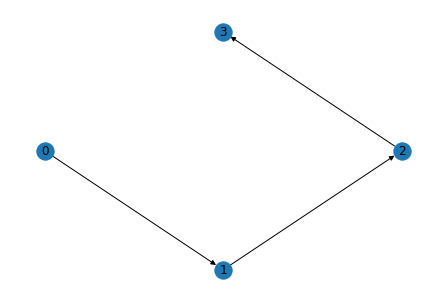

In [64]:
nx.draw_shell(gold_standard, with_labels=True)

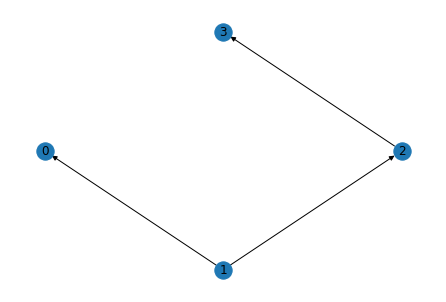

In [65]:
nx.draw_shell(nt_pred_nx, with_labels=True)

In [86]:
cdata_pert = cdata.copy()
cdata_pert[:, 3] = cdata_pert[:, 3] * (1/4)
cdata_pert[:, 2] = cdata_pert[:, 2] * (1/2)
cdata_pert[:, 1] = cdata_pert[:, 1] * 1
cdata_pert[:, 0] = cdata_pert[:, 0] * 2
cdata_pert.std(axis=0)

array([2.0163461 , 0.97011522, 0.4915154 , 0.24678626])

In [87]:
varsortability(chain, cdata_pert)

0.0

In [88]:
nt_pred_pert = nt.notears_linear(cdata_pert, 0.05, 'l2')
nt_pred_pert_nx = nx.convert_matrix.from_numpy_array(nt_pred_pert, create_using=nx.DiGraph)

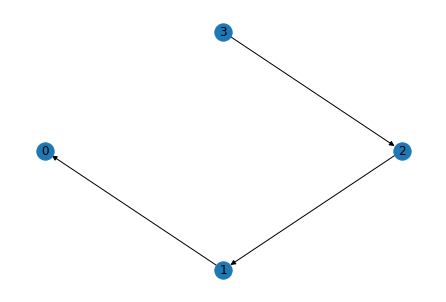

In [89]:
nx.draw_shell(nt_pred_pert_nx, with_labels=True)

In the case of chains, we can fully determine how the graph will look like in the end just by scaling the input for NOTEARS appropriately.

## Arbitrary DAGs
The next step is to try to find a pattern in order to force NOTEARS to output an arbitrary DAG as we determine it by scaling.

## Loss decomposition
The following function computes the loss of NOTEARS for the returned adjacency and decomposes it s.t. analysis of the result gets easier.

In [8]:
def loss_decomposition(adj, data, l1):
    lr_loss = np.linalg.norm(data - data @ adj, ord=2)
    regularization = l1 * np.linalg.norm(adj, ord=1)
    mexp = scipy.linalg.expm(adj * adj)
    acyclicity = np.sum(np.diagonal(mexp)) - adj.shape[0]
    loss = lr_loss + regularization + acyclicity
    return lr_loss, regularization, acyclicity, mexp, loss

## Reversing a chain by just changing one variable

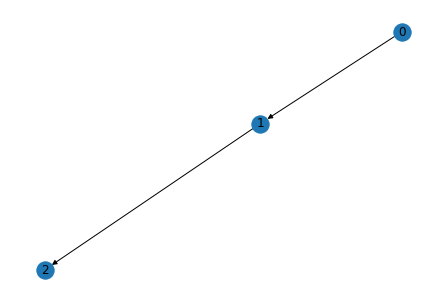

In [18]:
#adj = np.array([[0, 1, 0, 1],
#                [0, 0, 1, 0],
#                [0, 0, 0, 0],
#                [0, 0, 0, 0]])
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
# TODO: arrow heads + black-white contrast
nx.draw(G, with_labels=True)

In [19]:
X_0 = np.random.normal(0, 1, 1000)
# X2 = np.random.normal(0, 1, 1000)
X1 = X_0 + np.random.normal(0, 1, 1000)
X2 = X1 + np.random.normal(0, 1, 1000)
# X3 = X_0 + np.random.normal(0, 1, 1000)
gdata = np.array([X_0, X1, X2]).T
gdata = scale(gdata)

In [20]:
gdata.var(axis=0)

array([1., 1., 1.])

In [21]:
adj

array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

In [22]:
varsortability(adj, gdata)

0.8333333333333334

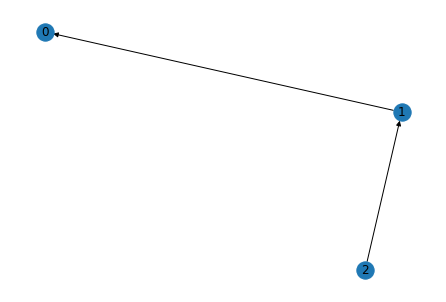

In [28]:
nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

In [96]:
# 3 < 2 = 0 < 1
gdata_copy = gdata.copy()
gdata_copy[:, 2] *= 2
# gdata_copy[:, 0] *= 2

In [97]:
gdata_copy.var(axis=0)

array([1., 1., 4.])

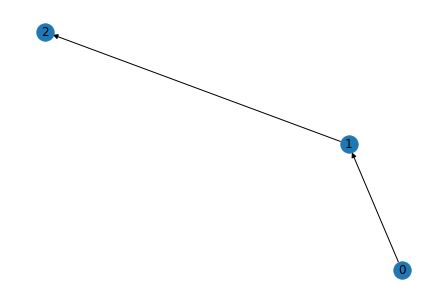

In [98]:
nt_pred = nt.notears_linear(gdata_copy, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

## Is this happening regularily?
The following two experiments will check if the above observation holds whenever the conditions hold described above.
See the flip-experiment-analysis notebook for this!

TODO: 
- Race condition checken

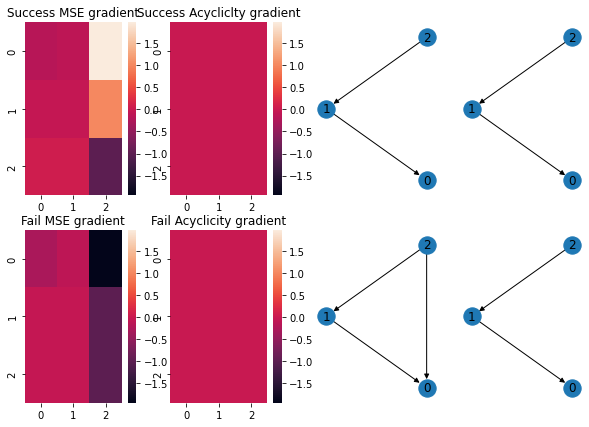

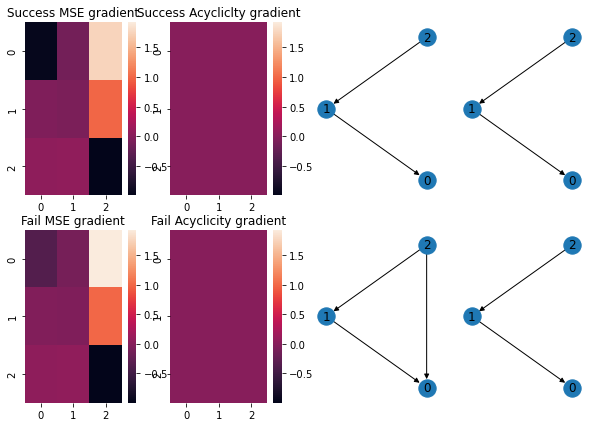

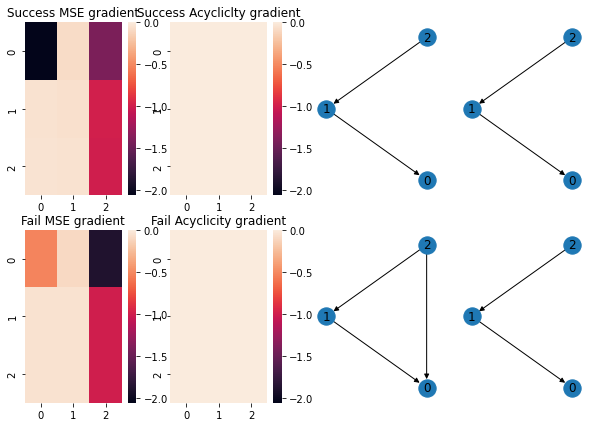

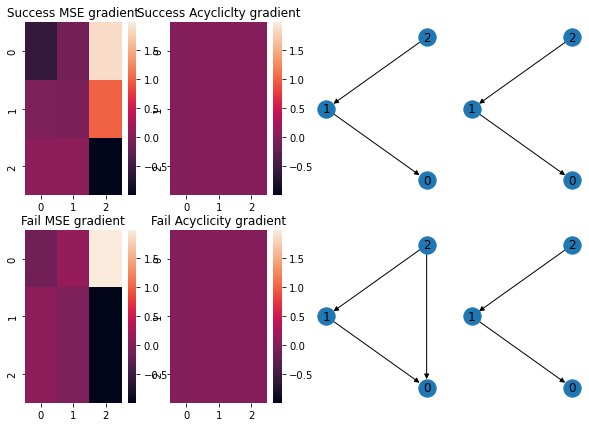

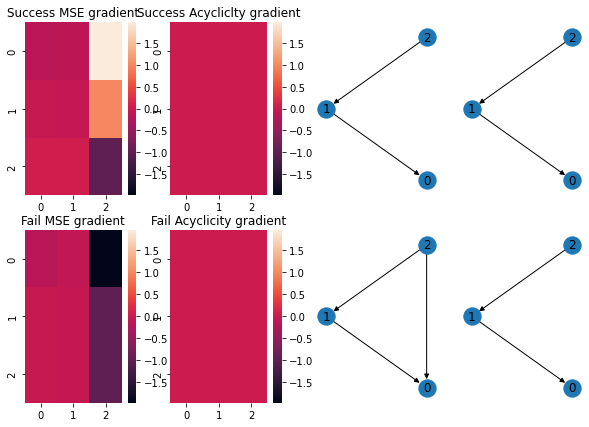

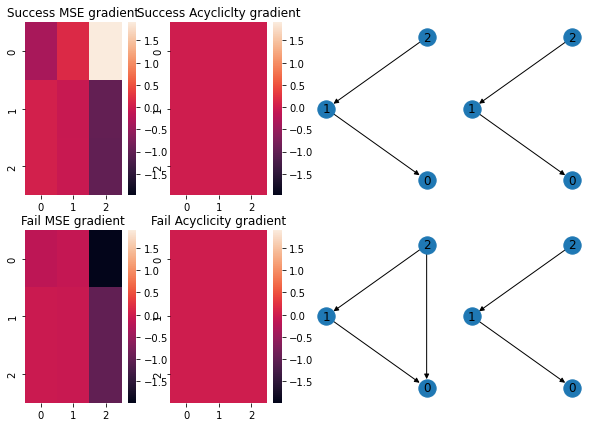

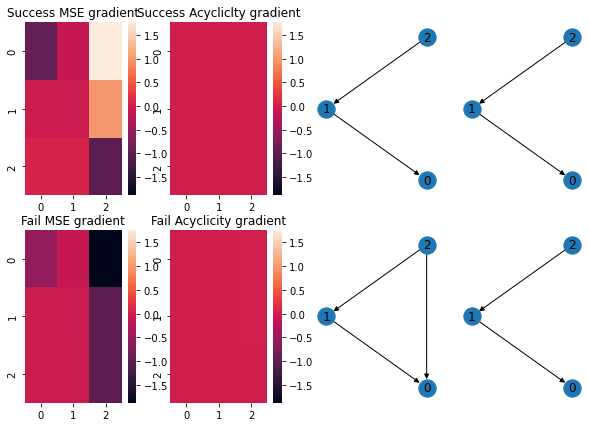

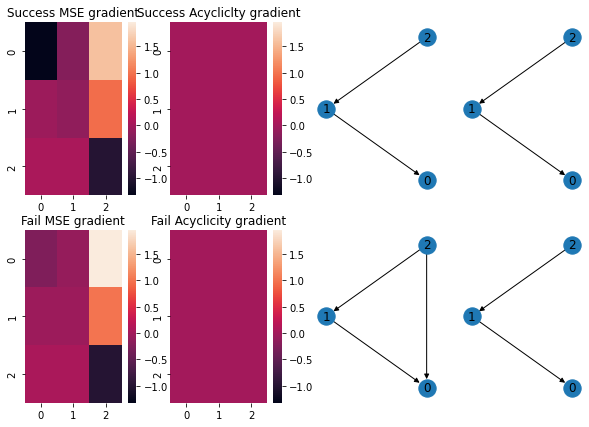

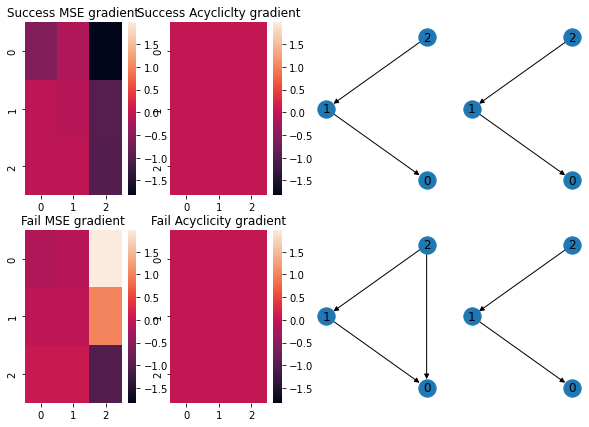

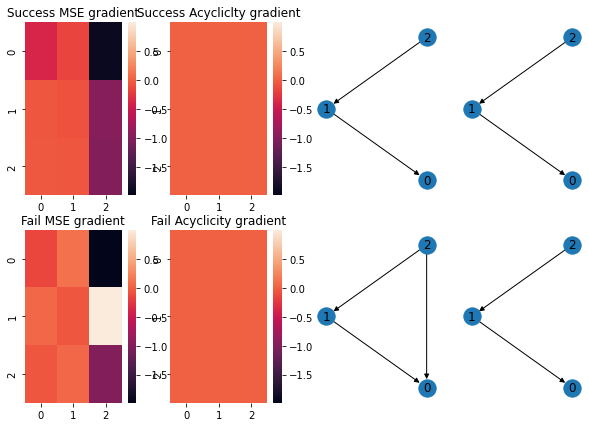

In [19]:
loss_gradient_path = './experiments/flip-experiment/gradients_{}/loss_gradients.csv'
acyc_gradient_path = './experiments/flip-experiment/gradients_{}/acyclicity_gradients.csv'
adj_path = './experiments/flip-experiment/adjacencies_{}/adj_{}.csv'
success_attacks = metadata_df[metadata_df['success'] == 1]
failed_attacks = metadata_df[metadata_df['success'] == 0]
G_true = nx.DiGraph()
G_true.add_edges_from([(1, 0), (2, 1)])
pos = nx.shell_layout(G_true)
for i in range(0, 10):
    # get information to obtain data for plot
    success_exp = int(success_attacks.iloc[i]['Exp'])
    failed_exp = int(failed_attacks.iloc[i]['Exp'])
    success_pid = int(success_attacks.iloc[i]['pid'])
    failed_pid = int(failed_attacks.iloc[i]['pid'])
    success_adj_nr = int(success_attacks.iloc[i]['adj_nr'])
    failed_adj_nr = int(failed_attacks.iloc[i]['adj_nr'])

    # read data
    suc_mse_gradient_df = pd.read_csv(loss_gradient_path.format(success_exp), index_col=0)
    suc_acyc_gradient_df = pd.read_csv(acyc_gradient_path.format(success_exp), index_col=0)
    fail_mse_gradient_df = pd.read_csv(loss_gradient_path.format(failed_exp), index_col=0)
    fail_acyc_gradient_df = pd.read_csv(acyc_gradient_path.format(failed_exp), index_col=0)
    suc_adj = pd.read_csv(adj_path.format(success_pid, success_adj_nr), index_col=0)
    fail_adj = pd.read_csv(adj_path.format(failed_pid, failed_adj_nr), index_col=0)

    # get last 3 rows of the gradient-dataset, i.e. the gradient of the last iteration of NT
    last_suc_mse_grad = suc_mse_gradient_df.tail(3)[['0', '1', '2']]
    last_suc_acyc_grad = suc_acyc_gradient_df.tail(3)[['0', '1', '2']]
    last_fail_mse_grad = fail_mse_gradient_df.tail(3)[['0', '1', '2']]
    last_fail_acyc_grad = fail_acyc_gradient_df.tail(3)[['0', '1', '2']]

    fig, axs = plt.subplots(2, 4, figsize=(10, 7))
    suc_mse_hax, suc_acyc_hax, suc_gax, t_gax1 = axs[0]
    fail_mse_hax, fail_acyc_hax, fail_gax, t_gax2 = axs[1]
    suc_mse_hax.set_title('Success MSE gradient')
    suc_acyc_hax.set_title('Success Acycliclty gradient')
    fail_mse_hax.set_title('Fail MSE gradient')
    fail_acyc_hax.set_title('Fail Acyclicity gradient')

    vmin = min(last_suc_mse_grad.min().min(), last_suc_acyc_grad.min().min(), last_fail_mse_grad.min().min(), last_fail_acyc_grad.min().min())
    vmax = max(last_suc_mse_grad.max().max(), last_suc_acyc_grad.max().max(), last_fail_mse_grad.max().max(), last_fail_acyc_grad.max().max())

    sns.heatmap(last_suc_mse_grad, vmin=vmin, vmax=vmax, ax=suc_mse_hax)
    sns.heatmap(last_suc_acyc_grad, vmin=vmin, vmax=vmax, ax=suc_acyc_hax)
    sns.heatmap(last_fail_mse_grad, vmin=vmin, vmax=vmax, ax=fail_mse_hax)
    sns.heatmap(last_fail_acyc_grad, vmin=vmin, vmax=vmax, ax=fail_acyc_hax)

    G_suc = nx.convert_matrix.from_numpy_array(suc_adj.to_numpy(), create_using=nx.DiGraph)
    G_fail = nx.convert_matrix.from_numpy_array(fail_adj.to_numpy(), create_using=nx.DiGraph)

    nx.draw(G_suc, pos, with_labels=True, ax=suc_gax)
    nx.draw(G_fail, pos, with_labels=True, ax=fail_gax)
    nx.draw(G_true, pos, with_labels=True, ax=t_gax1)
    nx.draw(G_true, pos, with_labels=True, ax=t_gax2)

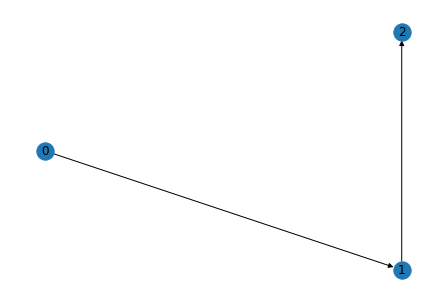

array([[0, 0, 0],
       [1, 0, 0],
       [0, 1, 0]])

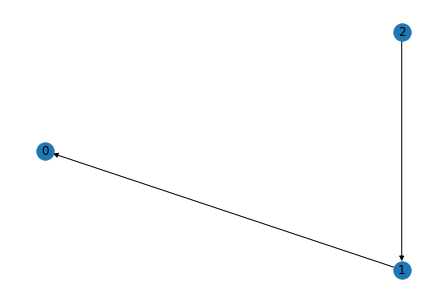

In [22]:
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
G_ = nx.convert_matrix.from_numpy_array(adj.T, create_using=nx.DiGraph)
nx.draw_shell(G, with_labels=True)
plt.show()
nx.draw_shell(G_, with_labels=True)
adj.T

## Results so far
Above we can see that NOTEARS indeed has a bias towards estimating a chain $X_1 \rightarrow X_2 \rightarrow X_3$ since in 75% of the cases this was the estimation of NOTEARS. This would support my conjecture of a "race condition" in the optimization process. However, one question remains: Why does NOTEARS estimate a chain in 100% of all cases if all linear equations in the data generating process have a factor of 1?

It can be seen that scaling the data in the data generating process somehow manifests in the dependencies although we scale all data s.t. $Var(X) = 1$ and $\mu = 0$ afterwards.
Questions that arise:
1. What happens to a random variable $Y = cX + \epsilon$ if it is first scaled by $c$ and standardized afterwards where $X, \epsilon \sim \mathcal{N}$, $c \in \mathbb{R}$? Which information is added here that leads to a change of the Linear Regression results?
    - the slope of the data is changed, however the overall structure is preserved. This could have an impact on the MSE, but should not have an impact on the optimization problem's solution solved by NOTEARS.
2. Why does this not happen for $c=1$?
3. What are implications of 1. to MSE and NOTEARS?
    - see 1.
4. What happens to the MSE/NOTEARS loss if the first coefficient ranges between 2 and 4?
5. Is there an upper limit of the values of the first coefficient where the obtained failure is not occuring anymore?
6. Is this symmetric? I.e. do the same once with negative values

The image above shows that there is a pattern which seems to predict the success of an attack pretty well. Especially the first coefficient seems to be a good predictor and thus it has a big influence on whether the attack succeeds or fails. It can be seen that the choice of the second parameter is independent of the attack's success, only if the first parameter is taken into account, we can see that the attack often fails if $- 5 < c_1 < 5$. However, experiments also have shown that in the case when $c_1 = c_2 = 1$ the attack succeeds. 

The next step is now to find the reason why the attack fails that often if the first parameter is chosen from the interval $[-5, 5]$.

## Creating a fork

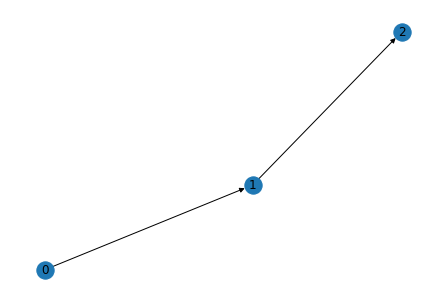

In [19]:
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

In [20]:
X_0 = np.random.normal(0, 1, 1000)
# X2 = np.random.normal(0, 1, 1000)
X1 = X_0 + np.random.normal(0, 1, 1000)
X2 = X1 + np.random.normal(0, 1, 1000)
# X3 = X_0 + np.random.normal(0, 1, 1000)
gdata = np.array([X_0, X1, X2]).T
gdata = scale(gdata)

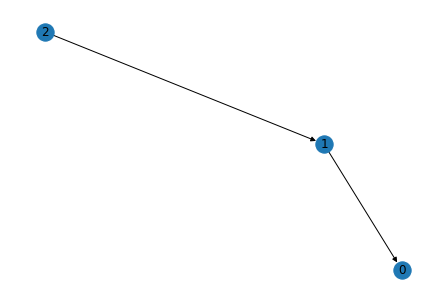

In [19]:
nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

In [20]:
gdata_copy = gdata.copy()
gdata_copy[:, 2] *= 2
gdata_copy[:, 0] *= 2

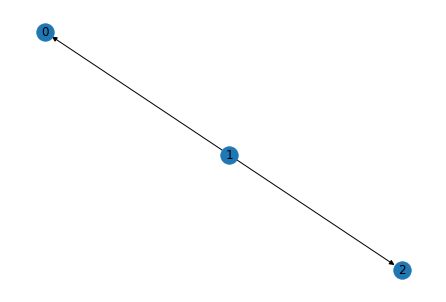

In [21]:
nt_pred = nt.notears_linear(gdata_copy, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

## Create a new collider

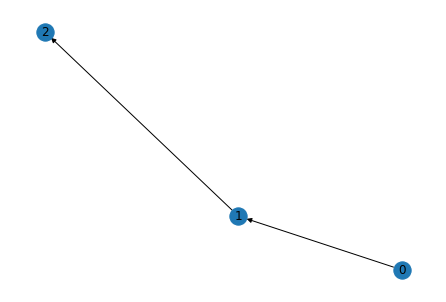

In [22]:
adj = np.array([[0, 1, 0],
                [0, 0, 1], 
                [0, 0, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)
X_0 = np.random.normal(0, 1, 1000)
# X2 = np.random.normal(0, 1, 1000)
X1 = X_0 + np.random.normal(0, 1, 1000)
X2 = X1 + np.random.normal(0, 1, 1000)
# X3 = X_0 + np.random.normal(0, 1, 1000)
gdata = np.array([X_0, X1, X2]).T
gdata = scale(gdata)

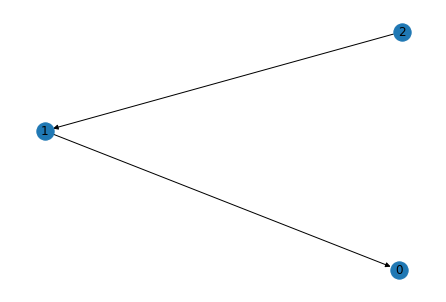

In [23]:
nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

In [24]:
gdata_copy = gdata.copy()
gdata_copy[:, 1] *= 2

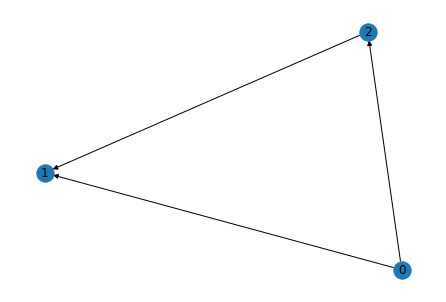

In [25]:
nt_pred = nt.notears_linear(gdata_copy, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

## Create non-collider from collider

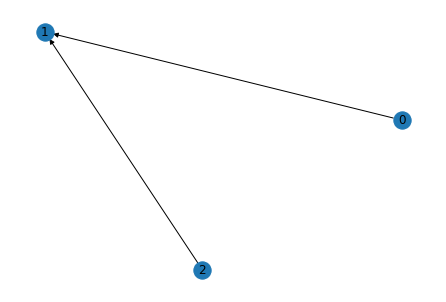

In [28]:
adj = np.array([[0, 1, 0],
                [0, 0, 0], 
                [0, 1, 0]])
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)
X_0 = np.random.normal(0, 1, 10000)
X2 = np.random.normal(0, 1, 10000)
X1 = X_0 + X2 + np.random.normal(0, 1, 10000)
# X3 = X_0 + np.random.normal(0, 1, 1000)
gdata = np.array([X_0, X1, X2]).T

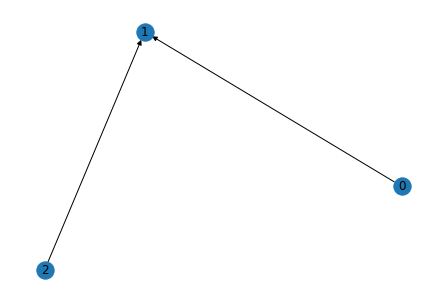

In [30]:
nt_pred = nt.notears_linear(gdata, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

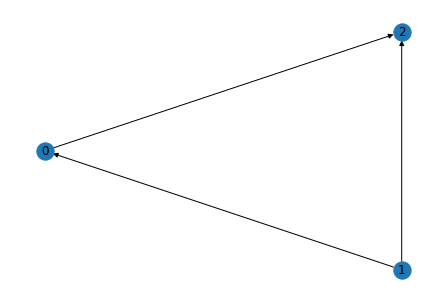

In [26]:
gdata = scale(gdata)
gdata_copy = gdata.copy()
gdata_copy[:, 0] *= 2
gdata_copy[:, 2] *= 2
nt_pred = nt.notears_linear(gdata_copy, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw_shell(nt_pred_nx, with_labels=True)

## The 4-variables case

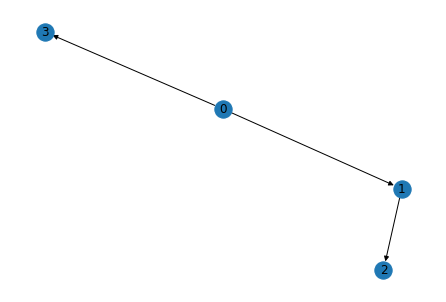

In [8]:
adj = np.array([[0, 1, 0, 1],
                [0, 0, 1, 0],
                [0, 0, 0, 0],
                [0, 0, 0, 0]])
X0 = np.random.normal(0, 1, 1000)
X1 = X0 + np.random.normal(0, 1, 1000)
X2 = X1 + np.random.normal(0, 1, 1000)
X3 = X0 + np.random.normal(0, 1, 1000)
data = np.array([X0, X1, X2, X3]).T
G = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)

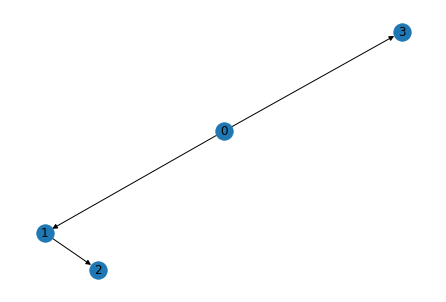

In [19]:
pred = nt.notears_linear(data, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred, create_using=nx.DiGraph)
nx.draw(G_pred, with_labels=True)

## Create a collider

In [20]:
cdata = data.copy()
cdata[:, 1] *= 2

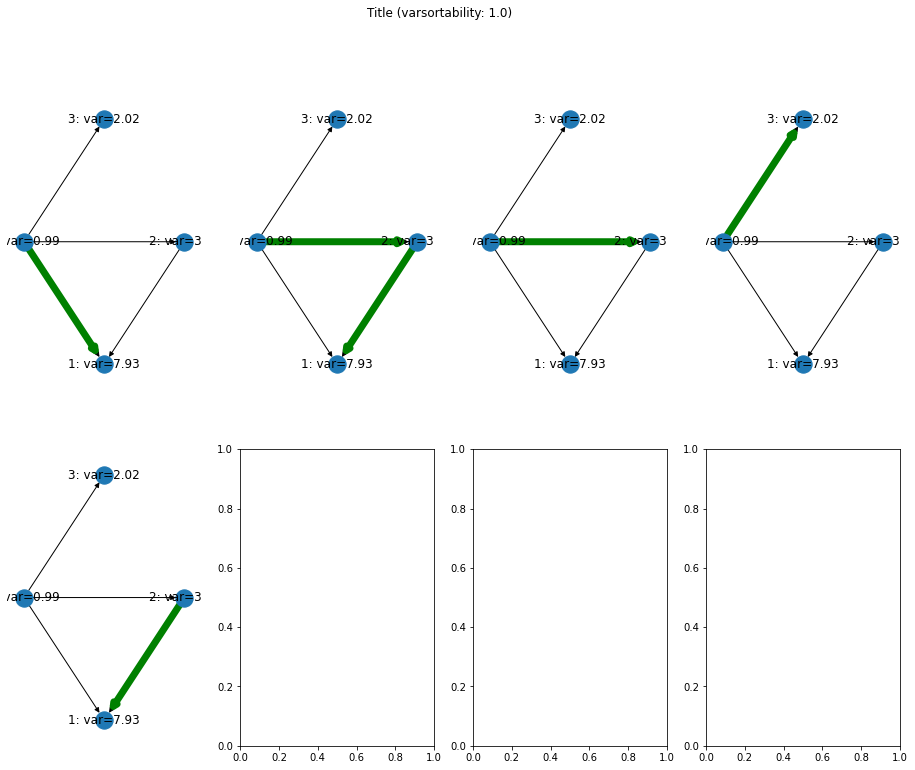

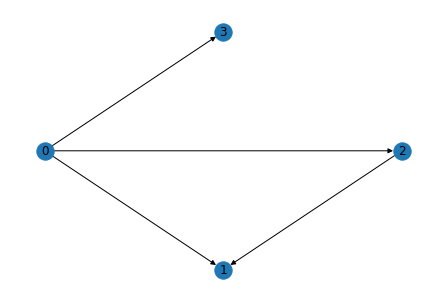

In [28]:
pred = nt.notears_linear(cdata, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred, create_using=nx.DiGraph)
pos = nx.shell_layout(G_pred)
draw_varsortability_graph(G_pred, cdata, pos, 'Title')
nx.draw(G_pred, pos, with_labels=True)

## Create a fork
Scaling only node 3 will not change anything since the same varsortability properties as in the original graph are obtained. Scaling only 0 will lead to a reversed edge between $X_3$ and $X_0$. However, the edge $X_0 \rightarrow X_1$ remains the same against the varsortability property. This is the case because if NOTEARS would reverse this edge, a new collider ($X_0$) would be created. Then NOTEARS would have to take into account the dependence between $X_1$ and $X_3$ with an edge which would lead to a higher score than letting the edge as it is.
This means that both, $X_0$ and $X_3$ must be scaled in order to create a fork at $X_1$. Scaling $X_0$ will force NOTEARS to reverse $X_0 \rightarrow X_1$ and scaling $X_3$ ensures that the edge $X_0 \rightarrow X_3$ doesn't reverse.

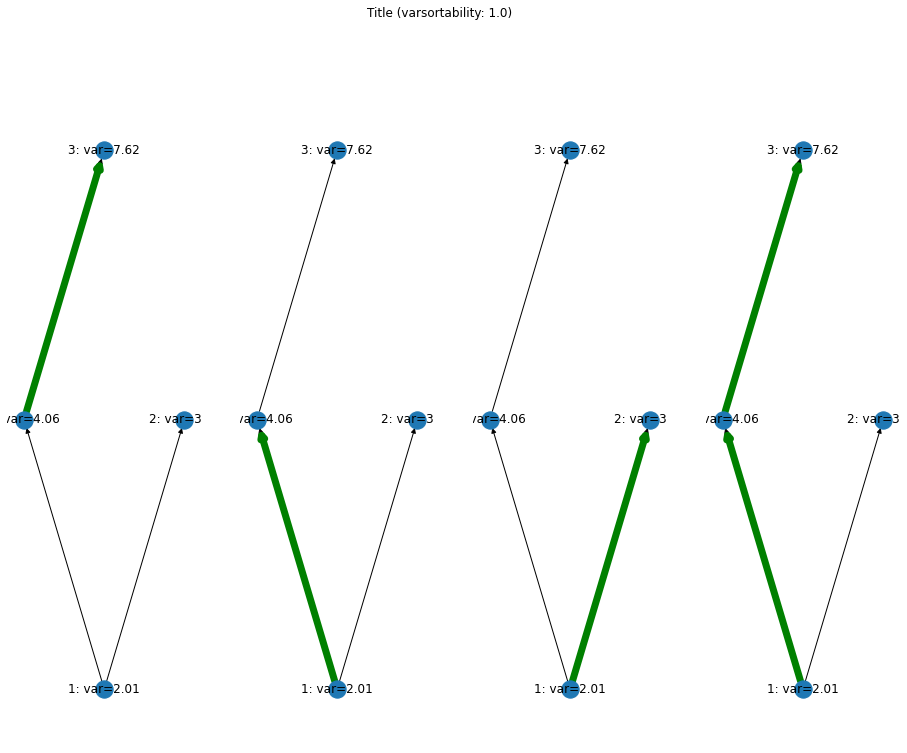

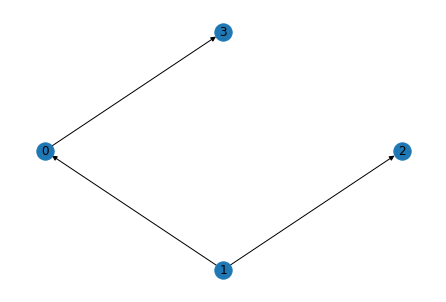

In [26]:
cdata = data.copy()
cdata[:, 0] *= 2
cdata[:, 3] *= 2
pred = nt.notears_linear(cdata, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred, create_using=nx.DiGraph)
pos = nx.shell_layout(G_pred)
draw_varsortability_graph(G_pred, cdata, pos, 'Title')
nx.draw(G_pred, pos, with_labels=True)

An interesting observation is that scaling $X_0$ s.t. $Var(X_0) = Var(X_1)$ will flip the edge between $X_0$ and $X_1$. Since by flipping the edge no dependence-relation is changed (thus no additional edge must be included) and since fitting a linear regression $X_0 \rightarrow X_1$ will be the same as $X_0 \leftarrow X_1$ in terms of MSE, the conjecture is that the edge flip is due to some regularization or due to the matrix exponential problem. However, the regularization term should be the same in both cases, which leads to the conjecture that the matrix exponential can indeed influence the output.

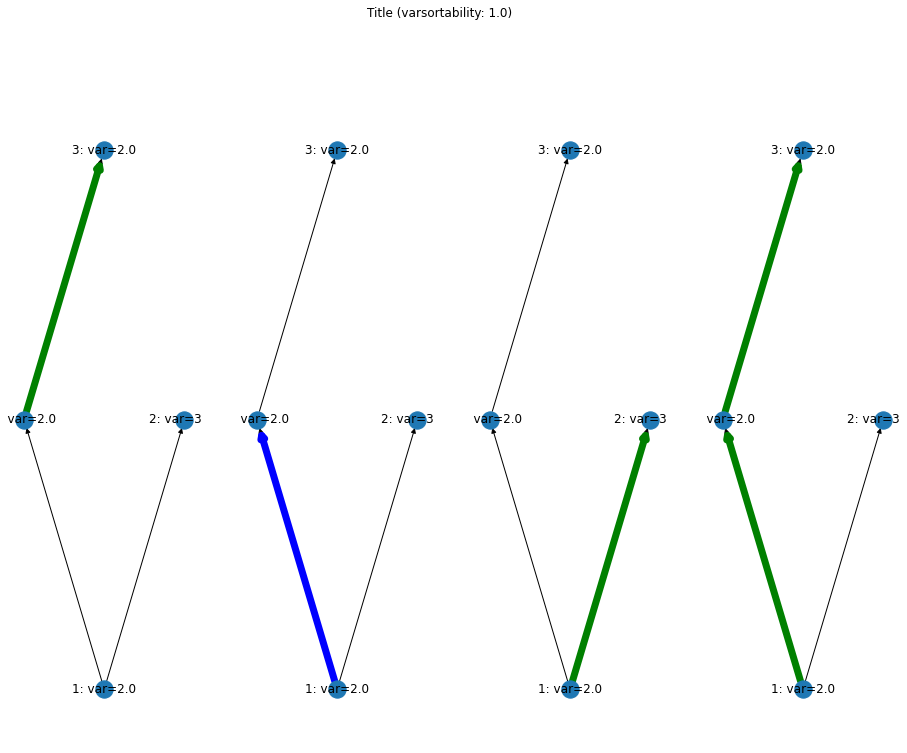

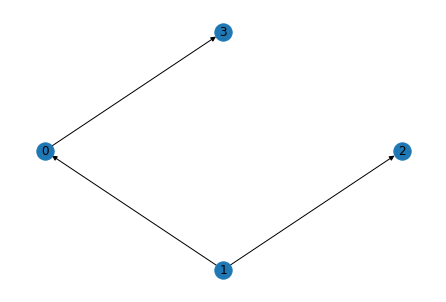

In [15]:
cdata = data.copy()
cdata[:, 0] *= (np.std(cdata[:, 1]) / np.std(cdata[:, 0]))
pred = nt.notears_linear(cdata, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred, create_using=nx.DiGraph)
pos = nx.shell_layout(G_pred)
draw_varsortability_graph(G_pred, cdata, pos, 'Title')
nx.draw(G_pred, pos, with_labels=True)

In [31]:
lr_x = LinearRegression()
lr_y = LinearRegression()
X = cdata[:, 0].reshape(-1 ,1)
Y = cdata[:, 1].reshape(-1, 1)
lr_x.fit(X, Y)
lr_y.fit(Y, X)

LinearRegression()

In [33]:
print(lr_x.coef_)
print(lr_y.coef_)

[[0.72286396]]
[[0.72286396]]


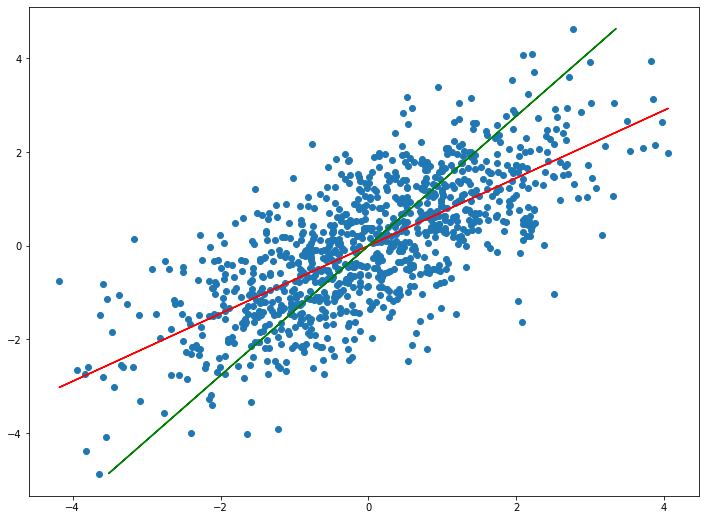

In [32]:
fig = plt.figure(figsize=(12, 9))
x_y_coef = lr_x.coef_.flatten()[0]
y_x_coef = lr_y.coef_.flatten()[0]
x_y_fit = x_y_coef * X
y_x_fit = y_x_coef * Y
plt.scatter(X, Y)
plt.plot(X, x_y_fit, color='red')
plt.plot(y_x_fit, Y, color='green')
plt.show()

## Creating chain
There are two ways to create a chain: 
1. scale all variables according to a certain order
2. only scale 0 s.t. $Var(2) < Var(1) = Var(2) < Var(3)$ then probably the matrix exponential problem will do the rest

If 0 is scaled s.t. $Var(0) > Var(3)$ and $Var(0) > Var(1)$, then a collider will be created and an additional edge between 1 and 3 is added. The collider is created due to varsortability and the additional edge is created because there is a dependence between 1 and 3 which wouldn't be respected if only the collider were created.

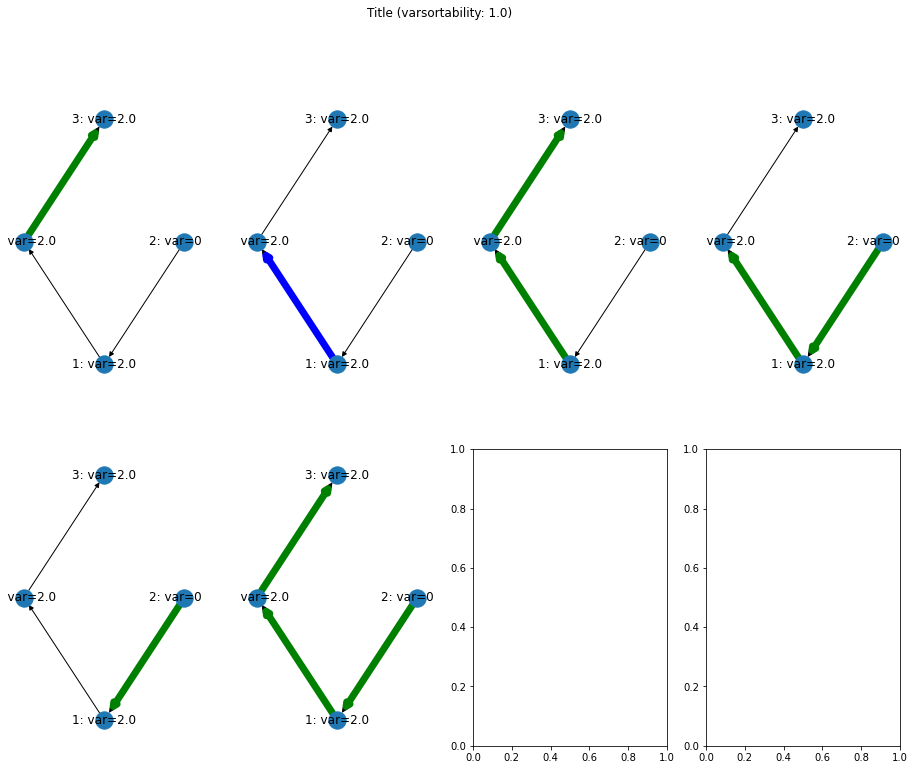

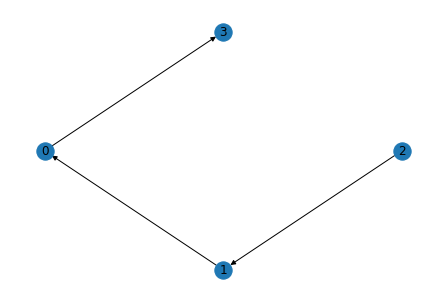

In [14]:
cdata = data.copy()
cdata[:, 0] *= (np.std(cdata[:, 1]) / np.std(cdata[:, 0]))
cdata[:, 2] *= 0.5
pred = nt.notears_linear(cdata, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred, create_using=nx.DiGraph)
pos = nx.shell_layout(G_pred)
draw_varsortability_graph(G_pred, cdata, pos, 'Title')
nx.draw(G_pred, pos, with_labels=True)

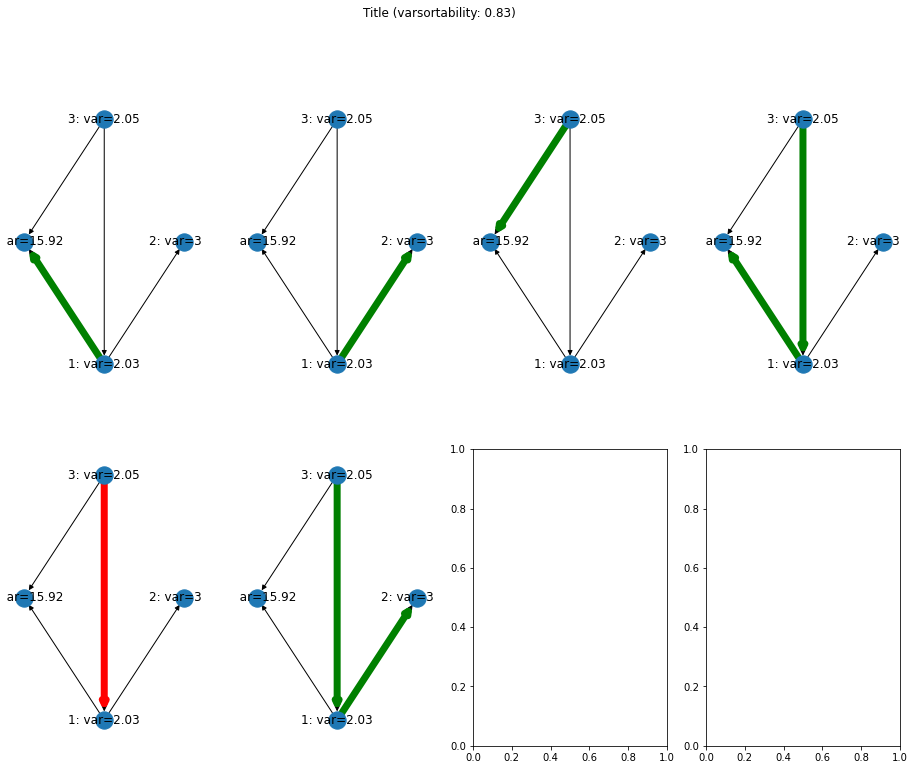

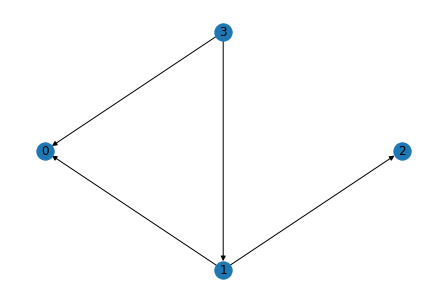

In [111]:
# creates a collider
cdata = data.copy()
cdata[:, 0] *= 4
pred_ = nt.notears_linear(cdata, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred_, create_using=nx.DiGraph)
pos = nx.shell_layout(G_pred)
draw_varsortability_graph(G_pred, cdata, pos, 'Title')
nx.draw(G_pred, pos, with_labels=True)

In [128]:
lr_loss, reg, acyc, mexp, loss = loss_decomposition(pred, cdata, 0.05)
print('lr_loss: {}'.format(lr_loss))
print('reg: {}'.format(reg))
print('acyc: {}'.format(acyc))
print('loss: {}'.format(loss))
mexp

lr_loss: 78.27226173606492
reg: 0.09813132488690993
acyc: 0.0
loss: 78.37039306095183


array([[1.        , 0.        , 0.        , 0.        ],
       [0.41127214, 1.        , 0.94980671, 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [1.78250819, 0.17807073, 0.08456639, 1.        ]])

In [132]:
lr_loss, reg, acyc, mexp, loss = loss_decomposition(pred_, cdata, 0.05)
print('lr_loss: {}'.format(lr_loss))
print('reg: {}'.format(reg))
print('acyc: {}'.format(acyc))
print('loss: {}'.format(loss))
mexp

lr_loss: 108.26303482478663
reg: 0.059695815825730664
acyc: 0.0
loss: 108.32273064061236


array([[1.        , 0.        , 0.        , 0.46920408],
       [1.42543617, 1.        , 0.94205904, 0.33441023],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])

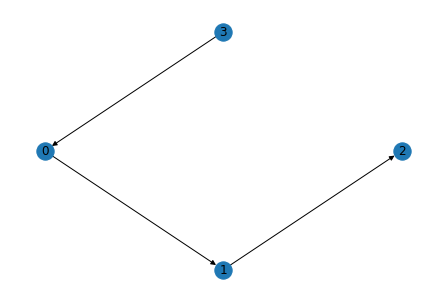

In [45]:
# creates a chain by sorting the variances
cdata = data.copy()
# since Var(3) = 2 * Var(0), ensure that Var(3) < Var(1) after scaling
cdata[:, 3] *= 0.5
cdata[:, 0] *= 2
cdata[:, 1] *= 2
cdata[:, 2] *= 2
pred = nt.notears_linear(cdata, 0.05, 'l2')
G_pred = nx.convert_matrix.from_numpy_array(pred, create_using=nx.DiGraph)
nx.draw_shell(G_pred, with_labels=True)

## Obervations
Disturbting the data in such a way that the resulting graph can be predicted is not a heavy task. Here are three rules that are enough for this:
1. In order to create a chain $X_1 \rightarrow ... \rightarrow X_n$, scale the data of the corresponding nodes s.t. the variance is sorted ascending from $1, ..., n$.
2. To create a collider $X_1 \rightarrow X_2 \leftarrow X_3$, scale data corresponding to $X_2$ s.t. $Var(X_1) < Var(X_2) > Var(3)$. Note that this will introduce a new edge because $X_1$ and $X_3$ are not independent in the data generating process.
3. To create a fork $X_n \leftarrow ... \leftarrow X_p \leftarrow X_f \rightarrow X_q \rightarrow ... \rightarrow X_m$ ensure that $Var(X_i) > Var(X_{i + 1})$ for all $i < f$ and $Var(X_j) > Var(X_j{j + 1})$ for all $j > f$. In words: The entire path that should be _entailed_ by the fork must have higher variance than $X_f$.

### New observations
1. In a chain $X_1 \rightarrow X_2 \rightarrow X_3$, scaling up $X_2$ will lead to $X_1 \rightarrow X_2 \leftarrow X_3$ and an additional edge between $X_1$ and $X_3$.
2. In a chain $X_1 \rightarrow X_2 \rightarrow X_3$, scaling up $X_1$ will lead to $X_1 \leftarrow X_2 \leftarrow X_3$.
3. In a chain $X_1 \rightarrow X_2 \rightarrow X_3$, scaling up $X_1$ and $X_3$ will lead to $X_1 \leftarrow X_2 \rightarrow X_3$.

## Checking paper's main result
Seems that there is a mistake...
1. Is here everything fine in my setup?
2. Observation: It's exactly the other way around

Reasoning why I'm checking this: NOTEARS essentially performs Lasso regression (plus some constraint). Since we know from regression that the MSE depends on the variance of the variable we fiting on, it should hold that the higher the variance of the response variable is, the higher the mean gets. However, varsortability states that NOTEARS prefers fitting linear regressions from lower variance-variables to higher variance-variables. This should lead to a higher MSE (which NOTEARS optimizes) than fitting the other way around. So the question is: Why does NOTEARS prefer the lower-to-higher variance direction?

In [45]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [34]:
w = 0.5
NX = np.random.normal(0, 1, 1000)
NY = np.random.normal(0, 1, 1000)
X = NX
Y = w*X + NY
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [37]:
X_scaled = scale(X)
Y_scaled = scale(Y)
print(X_scaled.var())
print(Y_scaled.var())
lr_x = LinearRegression()
lr_x.fit(X_scaled, Y_scaled)
lr_y = LinearRegression()
lr_y.fit(Y_scaled, X_scaled)

1.0000000000000002
1.0000000000000002


LinearRegression()

In [38]:
print(lr_x.coef_)
print(lr_y.coef_)

[[0.48871441]]
[[0.48871441]]


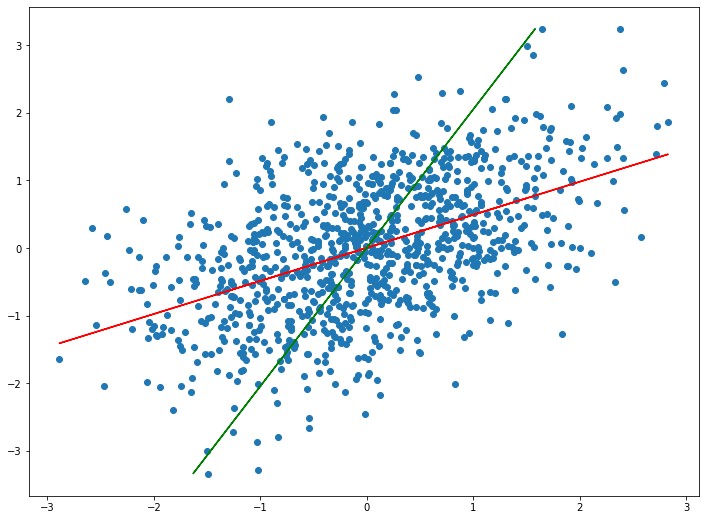

In [39]:
fig = plt.figure(figsize=(12, 9))
x_y_coef = lr_x.coef_.flatten()[0]
y_x_coef = lr_y.coef_.flatten()[0]
x_y_fit = x_y_coef * X_scaled
y_x_fit = y_x_coef * Y_scaled
plt.scatter(X_scaled, Y_scaled)
plt.plot(X_scaled, x_y_fit, color='red')
plt.plot(y_x_fit, Y_scaled, color='green')
plt.show()

In [64]:
print(X.var())
print(Y.var())

0.9206476471429489
1.2675285524168438


In [57]:
lr = LinearRegression()
lr.fit(X, Y)
pred_x_y = lr.predict(X)

In [58]:
mse_x_y = mean_squared_error(Y, pred_x_y)

In [59]:
lr = LinearRegression()
lr.fit(Y, X)
pred_y_x = lr.predict(Y)

In [60]:
mse_y_x = mean_squared_error(X, pred_y_x)

## Check $(1 - w^2)V_X < V_Y \implies MSE(X \rightarrow Y) < MSE(Y \rightarrow X)$

In [61]:
print((1 - w**2)*NX.var() < NY.var())
print(mse_x_y < mse_y_x)

True
False


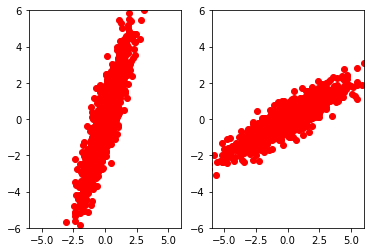

In [29]:
fig, ax = plt.subplots(1, 2)
ax[0].scatter(X, Y, color='red')
ax[1].scatter(Y, X, color='red')
ax[0].set_xlim([-6, 6])
ax[0].set_ylim([-6, 6])
ax[1].set_xlim([-6, 6])
ax[1].set_ylim([-6, 6])
plt.show()

## Observations
It can be seen that the MSE is bigger for $X_1 \rightarrow X_2$ if $var(X_1) < var(X_2)$ as if we fit $X_1 \leftarrow X_2$. However, the derivative for the fit $X_1 \rightarrow X_2$ is bigger than for the fit the other way around (at least in many cases). Thus, NOTEARS steps in this direction faster. The conjection is that due to the faster movement towards the worse fit, NOTEARS ends up in a local optimum.

## General algorithm for (systematically) pertubating output of NOTEARS

In [23]:
def pertubate_data(adj, data, scaling=1):
    adjc = adj.copy()
    datac = data.copy()
    # find all nodes having no parents
    incoming_nodes = adj.sum(axis=0)
    parentless = np.argwhere(incoming_nodes == 0).flatten()
    if adj.sum() == 0 or len(parentless) == 0:
        return data
    
    for node in parentless:
        datac[:, node] *= scaling
        outgoing_nodes = adjc[node, :]
        next_parentless = np.argwhere(outgoing_nodes == 1).flatten()
        for next_ in next_parentless:
            adjc[node, next_] = 0
        # mark column for node that was already scaled
        adjc[:, node] = -1
    return pertubate_data(adjc, datac, scaling + 1)

In [115]:
pert_data = pertubate_data(adj, scale(gdata))

In [116]:
varsortability(adj, pert_data)

1.0

In [99]:
adj

array([[0, 1, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [95]:
desired = np.array([[0, 0, 0, 0],
                    [1, 0, 0, 0],
                    [0, 0, 0, 0],
                    [1, 0, 1, 0]])

In [159]:
pert_data = pertubate_data(desired, gdata)

In [160]:
varsortability(desired, pert_data)

0.5

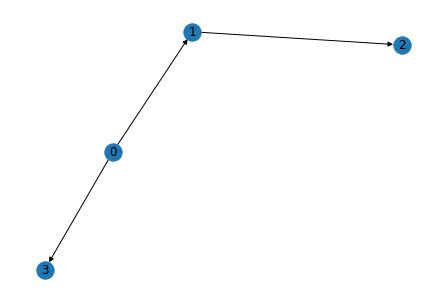

In [157]:
adj_nx = nx.convert_matrix.from_numpy_array(adj, create_using=nx.DiGraph)
nx.draw(adj_nx, with_labels=True)

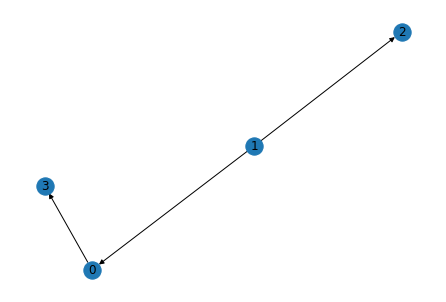

In [161]:
nt_pred = nt.notears_linear(pert_data, 0.05, 'l2')
nt_pred_nx = nx.convert_matrix.from_numpy_array(nt_pred, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

In [162]:
nt_pred

array([[0.        , 0.        , 0.        , 0.63831096],
       [0.64642878, 0.        , 0.77143117, 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

# Attack on Energy System

In this section the attack on NOTEARS is executed on a energy system dataset.

In [163]:
gold_standard = pd.read_csv('./repos/MasterThesis/notebooks/algorithm_comparisons/causal_discovery_on_energy_data/gold_standard.csv', index_col=0)
data = pd.read_csv('./repos/MasterThesis/notebooks/data_generation/energy_data/data_obs_gaussian.csv', index_col=0)
gold_standard

CostPV  CostBat  CostBuy  Demand  CapPV  CapBat  OwnGen  TOTEX  CAPEX
CostPV      0.0      0.0      0.0     0.0    1.0     0.0     0.0    0.0    1.0
CostBat     0.0      0.0      0.0     0.0    0.0     1.0     0.0    0.0    1.0
CostBuy     0.0      0.0      0.0     0.0    1.0     0.0     0.0    1.0    0.0
Demand      0.0      0.0      0.0     0.0    1.0     1.0     1.0    1.0    0.0
CapPV       0.0      0.0      0.0     0.0    0.0     1.0     1.0    0.0    1.0
CapBat      0.0      0.0      0.0     0.0    1.0     0.0     0.0    0.0    1.0
OwnGen      0.0      0.0      0.0     0.0    0.0     0.0     0.0    0.0    0.0
TOTEX       0.0      0.0      0.0     0.0    0.0     0.0     0.0    0.0    0.0
CAPEX       0.0      0.0      0.0     0.0    0.0     0.0     0.0    1.0    0.0

In [178]:
data

CostPV     CostBat   CostBuy       Demand     CapPV    CapBat  \
0    1016.023980  297.948947  0.258562  2438.824896  0.771115  1.269610   
1     744.923275  292.878715  0.220945  5572.462936  1.937866  2.668660   
2     299.600309  338.325644  0.324518  5016.397389  6.659310  7.475734   
3    1045.626516  308.114449  0.302694  3503.411514  1.325290  2.352988   
4    1064.411392  257.375945  0.309753  2693.317462  1.117380  2.263249   
..           ...         ...       ...          ...       ...       ...   
120  1631.488751  347.950332  0.150885  4664.487761  0.141849  0.054156   
121  1431.026231  281.990796  0.290964  2563.922770  0.663529  1.284926   
122   764.877581  365.953729  0.344653  4943.749696  2.773992  4.211524   
123  1377.707150  251.807713  0.239463  3020.905698  0.654491  1.242732   
124   780.695145  384.409945  0.350211  4656.344825  2.575513  3.880651   

       OwnGen        TOTEX       CAPEX  
0    0.308060   552.504336  116.175045  
1    0.314317  1066.734384  222.515507  
2    0.587343  1124.206550  452.436412  
3    0.346910   903.651282  211.074766  
4    0.374912   698.674493  177.185788  
..        ...          ...         ...  
120  0.043789   698.010735   25.026915  
121  0.280403   668.012052  131.186423  
122  0.416782  1360.031847  366.298703  
123  0.248963   664.759485  121.462581  
124  0.413029  1307.421752  350.245102  

[1000 rows x 9 columns]

In [182]:
pert_data = data.copy()
pert_data['CAPEX'] *= 15

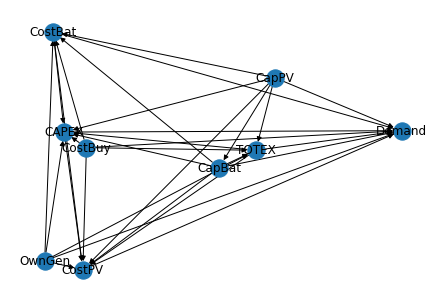

In [183]:
nt_pred = nt.notears_linear(pert_data.to_numpy(), 0.05, 'l2')
nt_pred_df = pd.DataFrame(nt_pred, columns=gold_standard.columns, index=gold_standard.index)
nt_pred_nx = nx.convert_matrix.from_pandas_adjacency(nt_pred_df, create_using=nx.DiGraph)
nx.draw(nt_pred_nx, with_labels=True)

In [184]:
nt_pred_df

CostPV    CostBat  CostBuy      Demand  CapPV    CapBat  OwnGen  \
CostPV     0.000000   0.000000      0.0   -1.115927    0.0  0.000000     0.0   
CostBat   -0.465477   0.000000      0.0   -2.655109    0.0  0.000000     0.0   
CostBuy   -7.824181   0.872050      0.0 -254.237586    0.0  0.000000     0.0   
Demand     0.000000   0.000000      0.0    0.000000    0.0  0.000000     0.0   
CapPV    -63.575402  71.491026      0.0  329.446530    0.0  0.769167     0.0   
CapBat   127.652388 -53.268973      0.0  239.964245    0.0  0.000000     0.0   
OwnGen  -185.736018 -31.748553      0.0 -379.570871    0.0  0.000000     0.0   
TOTEX      1.463260   0.000000      0.0    7.472593    0.0  0.000000     0.0   
CAPEX     -0.391558   0.000000      0.0   -1.387481    0.0  0.000000     0.0   

             TOTEX       CAPEX  
CostPV    0.000000    0.000000  
CostBat   0.000000   -0.482380  
CostBuy  11.755603   18.475812  
Demand    0.000000    0.000000  
CapPV   -29.372659  102.219593  
CapBat  -43.924264  290.901694  
OwnGen   22.433776  -32.655341  
TOTEX     0.000000    3.099800  
CAPEX     0.000000    0.000000

In [175]:
nt_pred = nt.notears_linear(data.to_numpy(), 0.05, 'l2')
nt_pred_df = pd.DataFrame(nt_pred, columns=gold_standard.columns, index=gold_standard.index)
nt_pred_nx = nx.convert_matrix.from_pandas_adjacency(nt_pred_df, create_using=nx.DiGraph)

In [176]:
nt_pred_df

CostPV    CostBat  CostBuy      Demand  CapPV    CapBat  \
CostPV     0.000000   0.000000      0.0   -1.145412    0.0  0.000000   
CostBat   -0.711447   0.000000      0.0   -2.716467    0.0  0.000000   
CostBuy   -6.215658   0.681787      0.0 -201.085727    0.0  0.000000   
Demand     0.000000   0.000000      0.0    0.000000    0.0  0.000000   
CapPV    -63.095508  73.392143      0.0  314.381635    0.0  3.065779   
CapBat   126.479242 -54.982263      0.0  253.795648    0.0  0.000000   
OwnGen  -144.737699 -24.650029      0.0 -296.428823    0.0 -3.460087   
TOTEX      1.767059   0.000000      0.0    7.605795    0.0  0.000000   
CAPEX     -6.897852   0.000000      0.0  -21.359583    0.0  0.000000   

           OwnGen      TOTEX      CAPEX  
CostPV   0.000000   0.000000   0.000000  
CostBat  0.000000   0.000000   0.000000  
CostBuy  0.000000   9.344770   0.693934  
Demand   0.000000   0.000000   0.000000  
CapPV    0.585722 -19.541373   6.212418  
CapBat   0.000000 -52.576170  20.515635  
OwnGen   0.000000  17.081580   0.000000  
TOTEX    0.000000   0.000000   0.000000  
CAPEX    0.000000   3.547652   0.000000

In [177]:
data

CostPV     CostBat   CostBuy       Demand     CapPV    CapBat  \
0    1016.023980  297.948947  0.258562  2438.824896  0.771115  1.269610   
1     744.923275  292.878715  0.220945  5572.462936  1.937866  2.668660   
2     299.600309  338.325644  0.324518  5016.397389  6.659310  7.475734   
3    1045.626516  308.114449  0.302694  3503.411514  1.325290  2.352988   
4    1064.411392  257.375945  0.309753  2693.317462  1.117380  2.263249   
..           ...         ...       ...          ...       ...       ...   
120  1631.488751  347.950332  0.150885  4664.487761  0.141849  0.054156   
121  1431.026231  281.990796  0.290964  2563.922770  0.663529  1.284926   
122   764.877581  365.953729  0.344653  4943.749696  2.773992  4.211524   
123  1377.707150  251.807713  0.239463  3020.905698  0.654491  1.242732   
124   780.695145  384.409945  0.350211  4656.344825  2.575513  3.880651   

       OwnGen        TOTEX       CAPEX  
0    0.308060   552.504336  116.175045  
1    0.314317  1066.734384  222.515507  
2    0.587343  1124.206550  452.436412  
3    0.346910   903.651282  211.074766  
4    0.374912   698.674493  177.185788  
..        ...          ...         ...  
120  0.043789   698.010735   25.026915  
121  0.280403   668.012052  131.186423  
122  0.416782  1360.031847  366.298703  
123  0.248963   664.759485  121.462581  
124  0.413029  1307.421752  350.245102  

[1000 rows x 9 columns]

## Varsortability visualization
The following code visualizes paths representing the varsortability visually. If a path's start node's variance is smaller than the end node's variance, then the edge will be green, else it will be red.

In [6]:
def draw_all_graphs(truth, est, desired, desired_est, original_data, pert_data):
    pos = nx.shell_layout(truth)
    plot_ground_truth_vs_estimation(truth, est, desired, desired_est, pos)
    draw_varsortability_graph(truth, original_data, pos, 'Ground truth')
    draw_varsortability_graph(est, original_data, pos, 'Estimated graph')
    draw_varsortability_graph(desired, pert_data, pos, 'Desired graph')
    draw_varsortability_graph(desired_est, pert_data, pos, 'Estimation of desired graph')

In [7]:
def draw_varsortability_graph(G, X, pos, title=''):
    nodes = G.nodes
    edges = []
    for i, j in itertools.product(nodes, nodes):
        paths = list(nx.all_simple_paths(G, i, j))
        if len(paths) > 0:
            for p in paths:
                edge_list = build_edge_list(p)
                # due to rounding errors & some randomness the variance of two variables can differ, although they're variance-parameter was the same when drawing
                i_var = np.round(np.var(X[:, i]), 5)
                j_var = np.round(np.var(X[:, j]), 5)
                if i_var < j_var:
                    edges.append((edge_list, 'green'))
                elif i_var > j_var:
                    edges.append((edge_list, 'red'))
                else:
                    edges.append((edge_list, 'blue'))
    
    rows = int(np.ceil(len(edges) / 4))
    fig, axes = plt.subplots(nrows=rows, ncols=4, figsize=(16, 12))
    ax = axes.flatten()
    variances = np.round(np.var(X, axis=0), decimals=2)
    label_dict = {i: '{}: var={}'.format(i, variances[i]) for i in nodes}
    for i in range(len(edges)):
        nx.draw(G, pos=pos, ax=ax[i], with_labels=True, labels=label_dict)
        nx.draw_networkx_edges(G, pos=pos, ax=ax[i], edgelist=edges[i][0], width=7, edge_color=edges[i][1])
        ax[i].set_axis_off()

    varsortability_score = np.round(varsortability(nx.convert_matrix.to_numpy_array(G), X), 2)
    fig.suptitle(title + ' (varsortability: {})'.format(varsortability_score))
    plt.show()
    plt.close()

In [8]:
def plot_ground_truth_vs_estimation(truth, est, desired, desired_est, pos):
    t_edges = truth.edges
    e_edges = est.edges
    d_edges = desired.edges
    de_edges = desired_est.edges
    fig, axes = plt.subplots(2, 2, figsize=(16, 9))
    ax = axes.flatten()
    def draw_graph_in_grid(ax_idx, iteration_edges, compare_edges, graph):
        nx.draw(graph, pos=pos, ax=ax[ax_idx], with_labels=True)
        different_edges = []
        for edge in iteration_edges:
            if edge not in compare_edges:
                different_edges.append(edge)
        nx.draw_networkx_edges(graph, pos=pos, ax=ax[ax_idx], edgelist=different_edges, width=5)
    
    draw_graph_in_grid(0, t_edges, e_edges, truth)
    draw_graph_in_grid(1, e_edges, t_edges, est)
    draw_graph_in_grid(2, d_edges, de_edges, desired)
    draw_graph_in_grid(3, de_edges, d_edges, desired_est)

    ax[0].set_title('Ground truth')
    ax[1].set_title('Estimation')
    ax[2].set_title('Desired graph')
    ax[3].set_title('Desired Estimation')
    plt.show()
    plt.close()
    

In [9]:
def build_edge_list(nodes): 
    edges = [(nodes[i], nodes[i + 1]) for i in range(0, len(nodes) - 1)]
    return edges

In [79]:
path = './experiments/small_data/'
metadata_lin_gauss = pd.read_csv(path + '/data/metadata.csv', index_col=0)
metadata_lin_gauss

sample_noise sample_weights       f  samples  \
0     gaussian  weight_sample  linear    10000   
0     gaussian  weight_sample  linear     1000   
0     gaussian  weight_sample  linear      100   
0     gaussian  weight_sample  linear      100   
0     gaussian  weight_sample  linear      100   
0     gaussian  weight_sample  linear    10000   
0     gaussian  weight_sample  linear     1000   
0     gaussian  weight_sample  linear     1000   
0     gaussian  weight_sample  linear    10000   

   common_cause_to_confounder_fraction  nodes  edges  \
0                                    0      4      5   
0                                    0      4      3   
0                                    0      4      4   
0                                    0      4      5   
0                                    0      4      3   
0                                    0      4      4   
0                                    0      4      5   
0                                    0      4      4   
0                                    0      4      3   

                                    dataset     graph_name  
0  4bb62f57-46e6-4d4d-a85a-563585d2472e.csv  graph_4_7.csv  
0  389cdb13-c741-496d-abb3-b58631d04883.csv  graph_4_6.csv  
0  16dec4bd-2766-4a7d-92eb-d12f86058723.csv  graph_4_3.csv  
0  01edcf79-f1d5-4f8b-8eef-ebb6156ddd21.csv  graph_4_7.csv  
0  10eb2235-9690-4e54-8e91-f4959ab84bed.csv  graph_4_6.csv  
0  6410d84c-db11-4e1b-b533-b2b51662522a.csv  graph_4_3.csv  
0  691b98ba-3a04-44b9-9688-0fa20c15bedb.csv  graph_4_7.csv  
0  e2418e1c-dff5-44c9-9d92-04b00a771ebc.csv  graph_4_3.csv  
0  dbfa662f-c6a3-4c56-93a4-67f12f5e5a5c.csv  graph_4_6.csv

## Idea
- Maybe we can somehow cluster the graphs and find patterns based on this?
- if we can cluster the graphs, can we train a classifier and estiamte feature importance?

- maybe we can define a coverage-measure and measure how much the following combinations match:
    - ground truth - estimation
    - desired graph - desired estimation
    - ground truth - desired estimation
    - desired graph - estimation

- maybe try to start from really simple cases (three nodes, one collider/common cause) and try to pertubate data s.t. desired graph is the output and then subsequently add complexity to graph

In [44]:
dag_generator = DAGGenerator()
dag = dag_generator.generate_dag()
nx.is_directed_acyclic_graph(dag.graph)

Generated graph with 5 nodes and 5 edges


True

In [50]:
def is_sparse(node_num, edge_num):
    if (edge_num / node_num) < 1:
        return True
    else:
        return False

Generated graph with 4 nodes and 10.0 edges


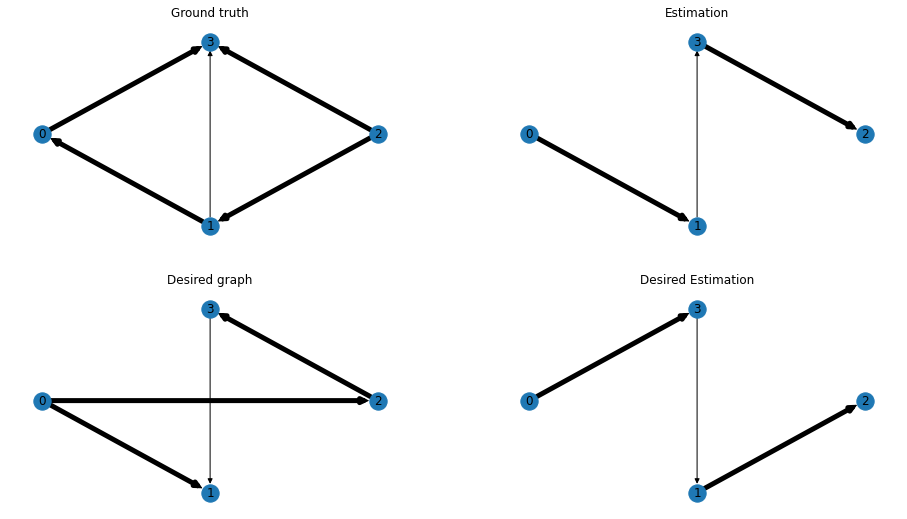

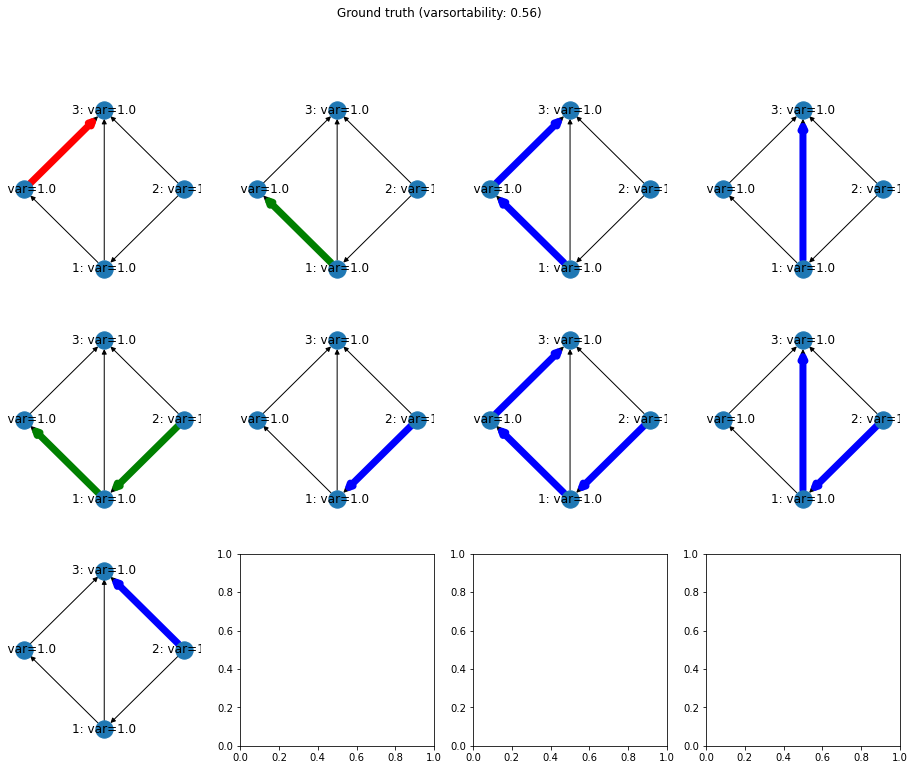

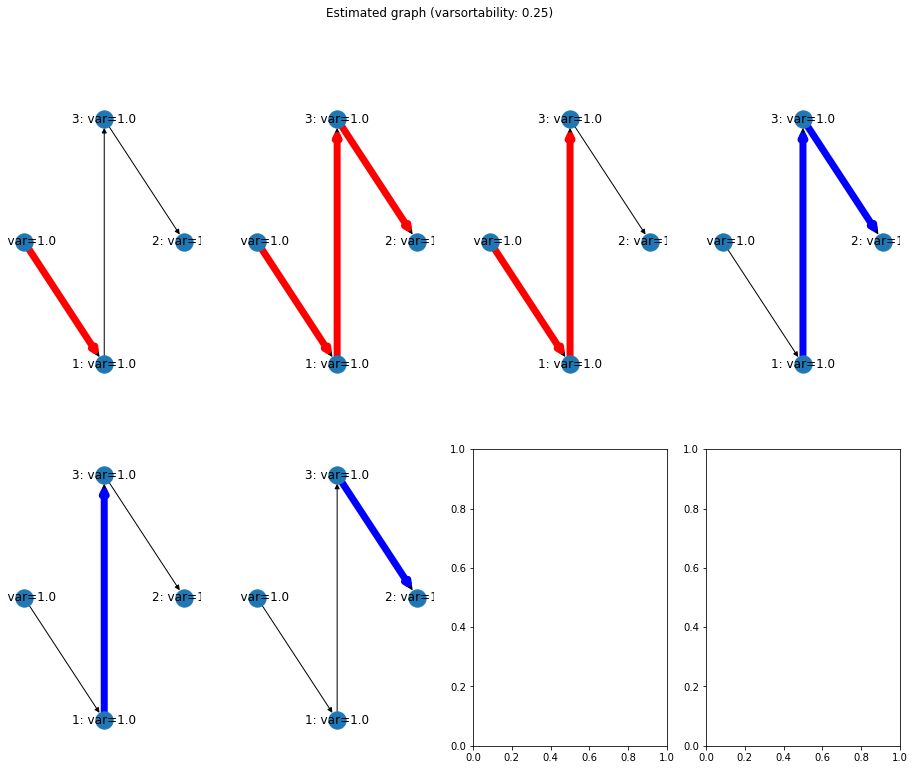

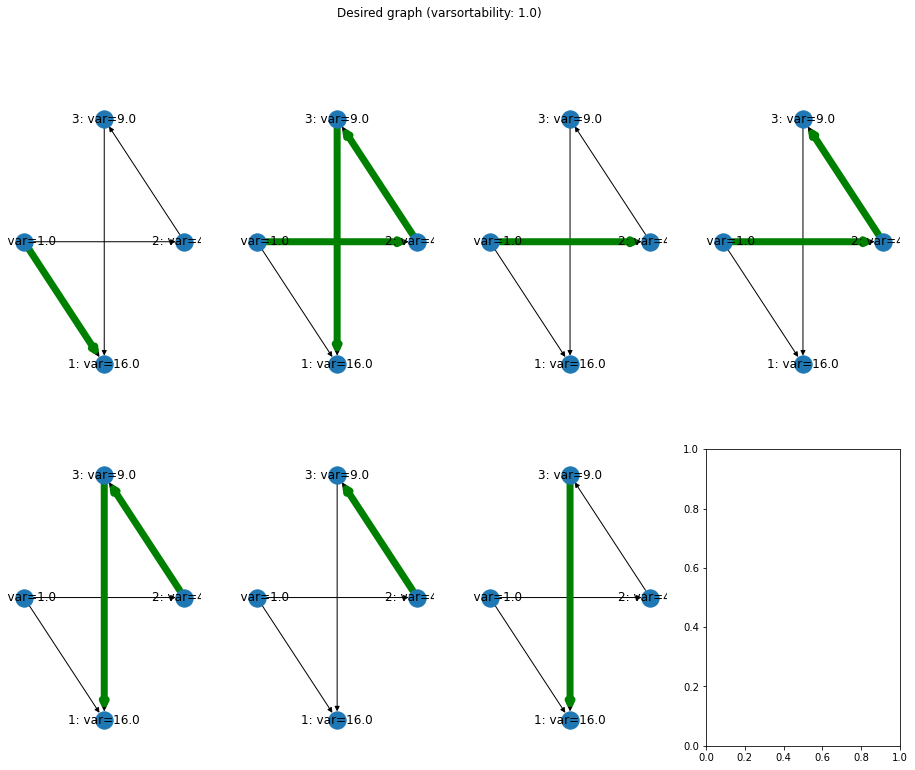

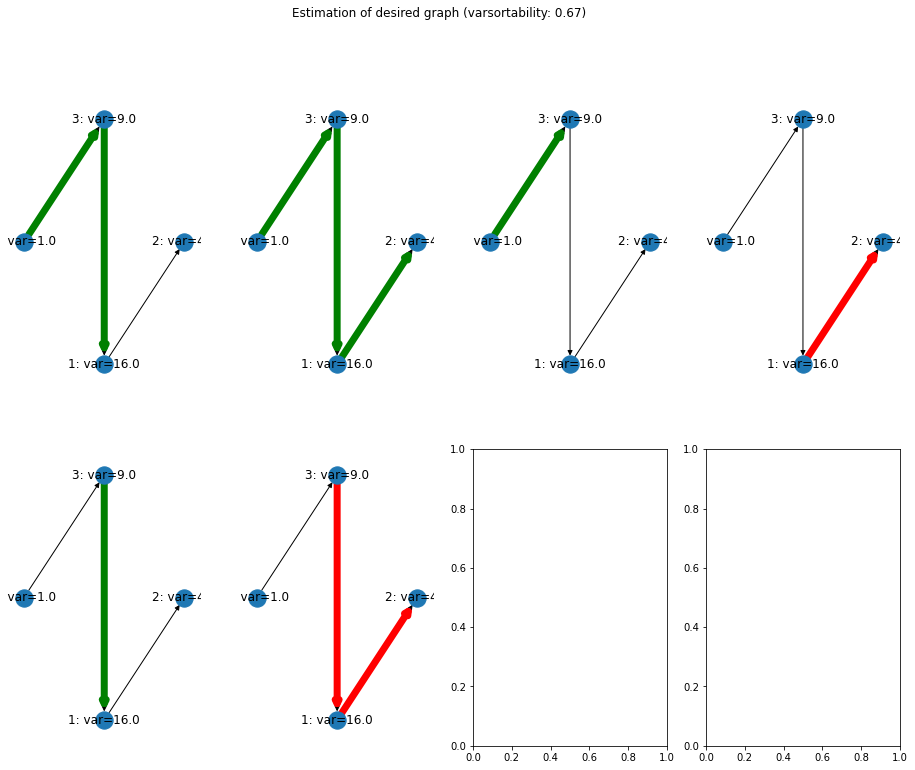

Generated graph with 4 nodes and 6.0 edges


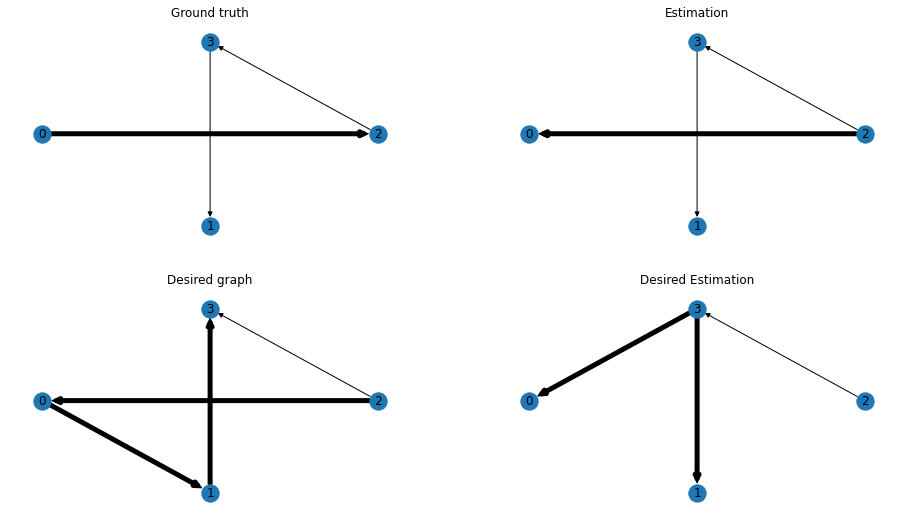

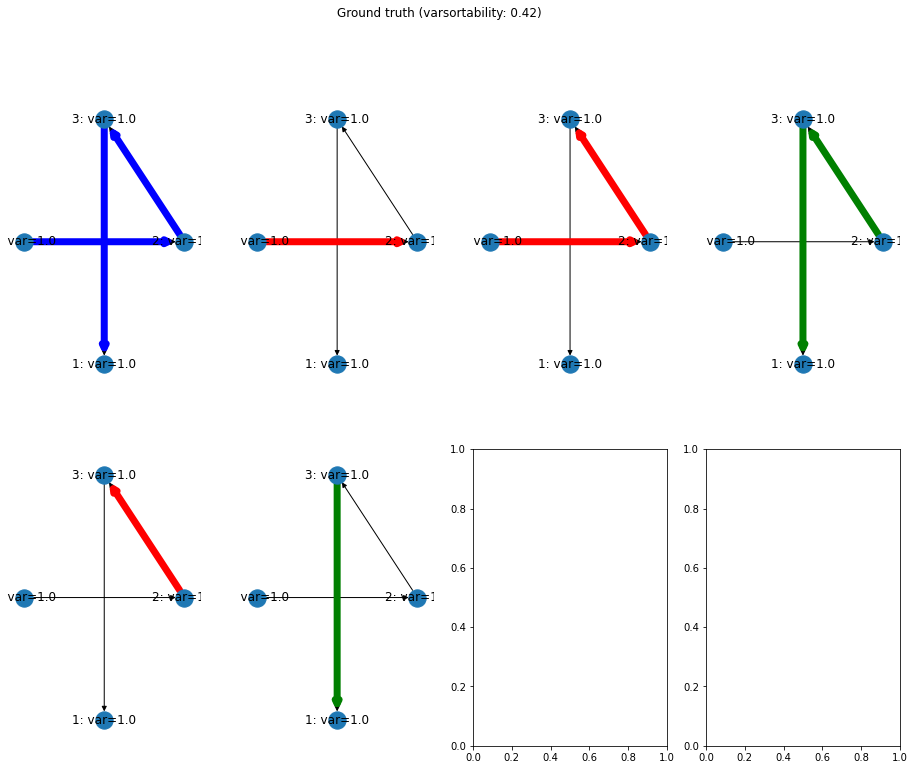

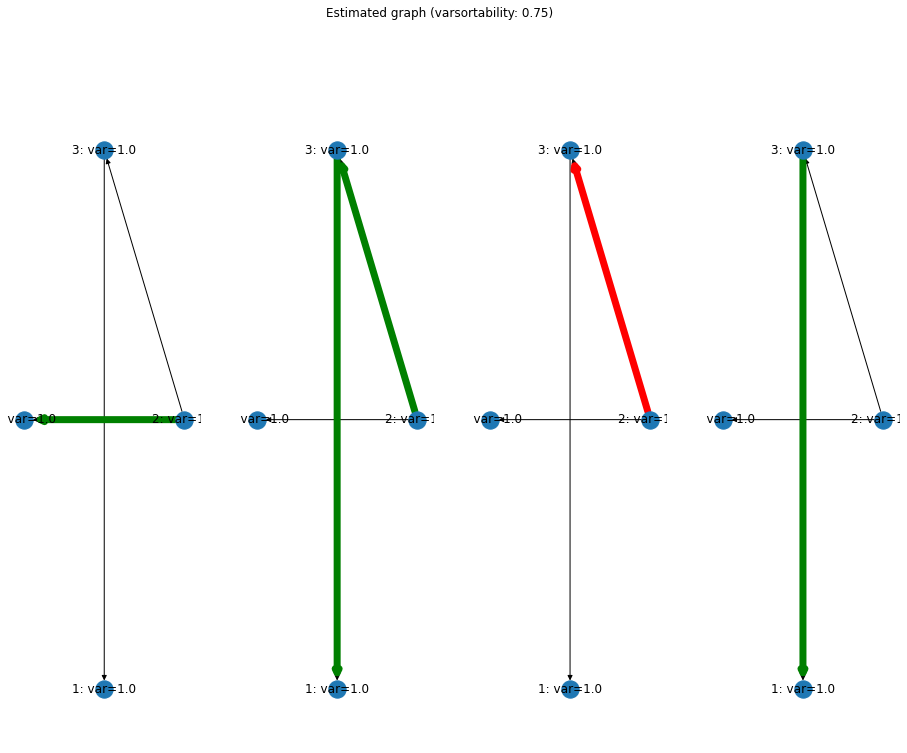

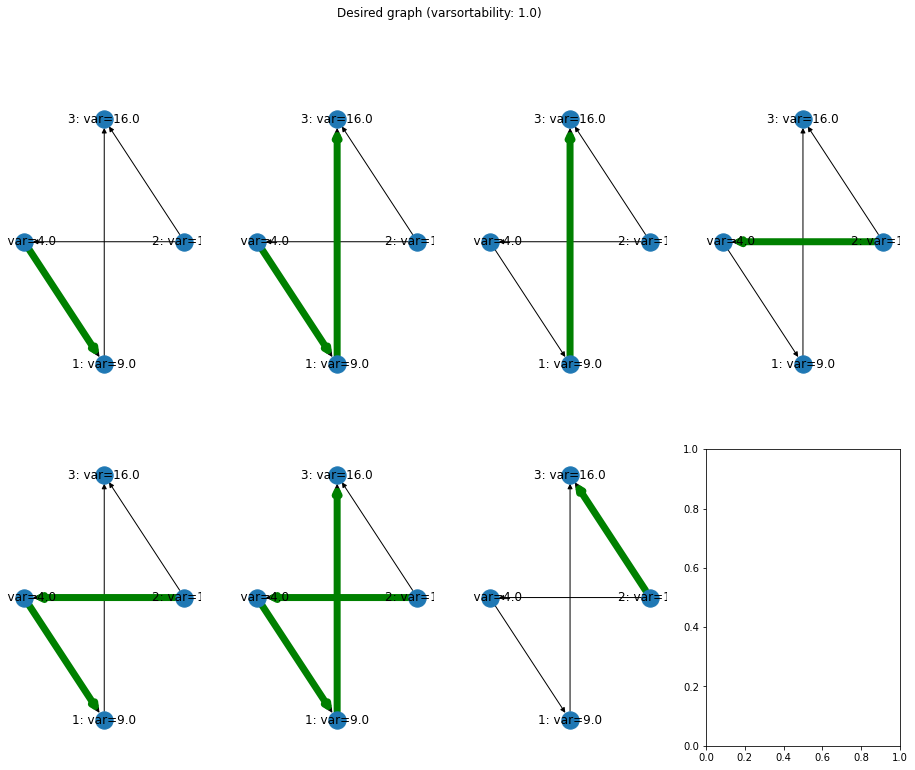

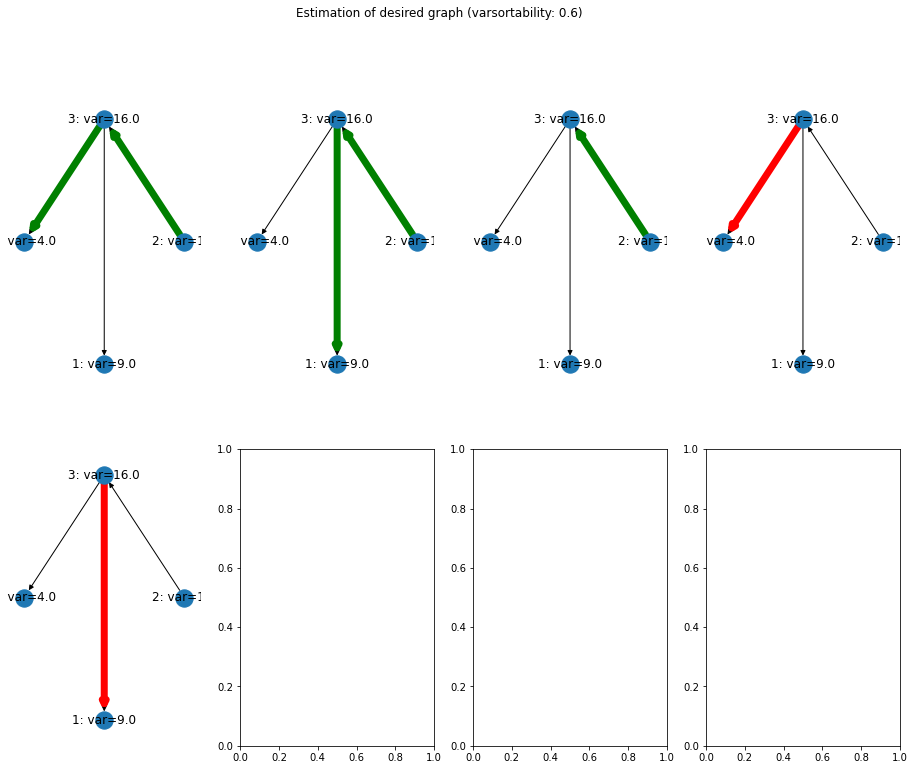

Generated graph with 4 nodes and 8.0 edges


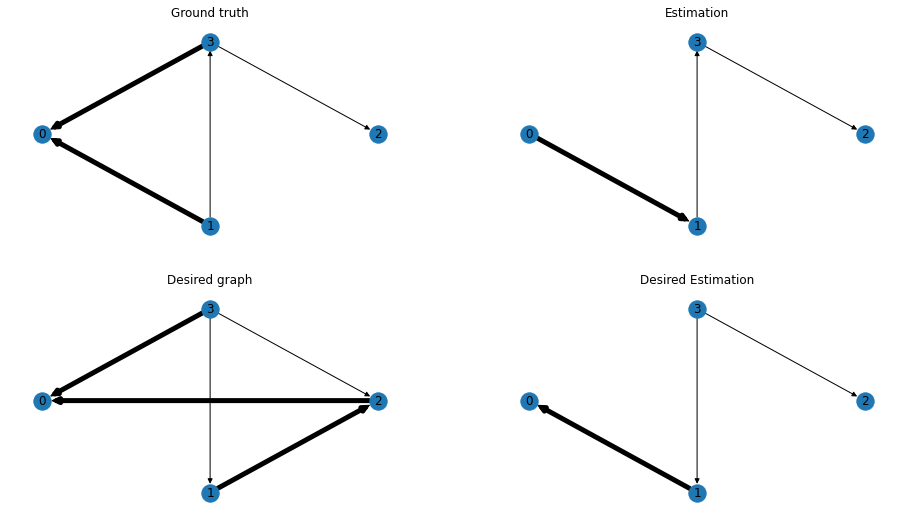

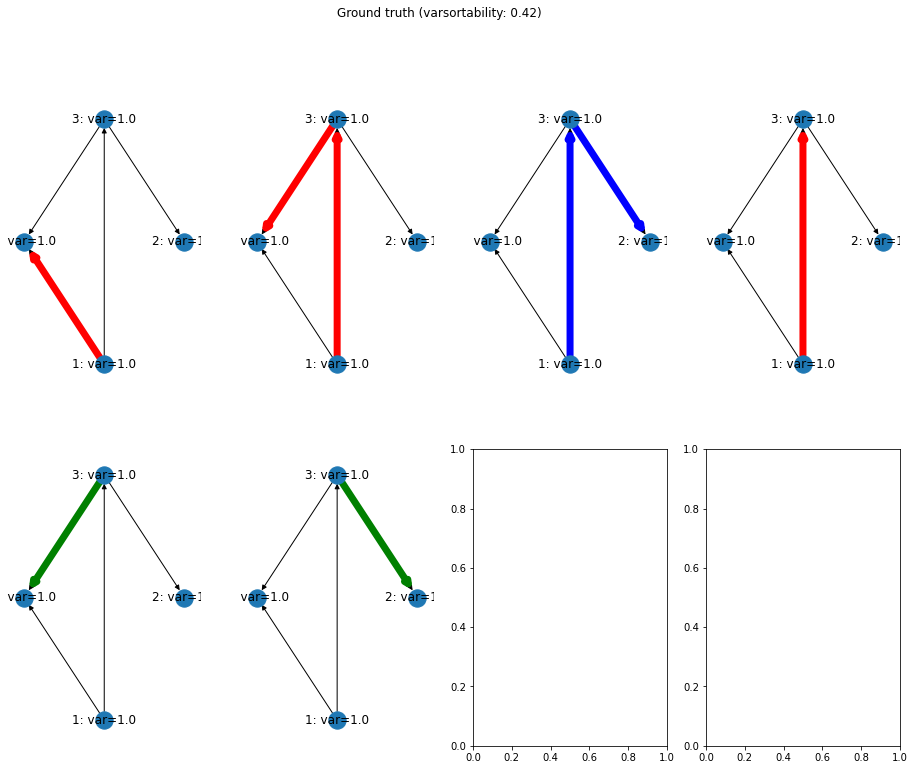

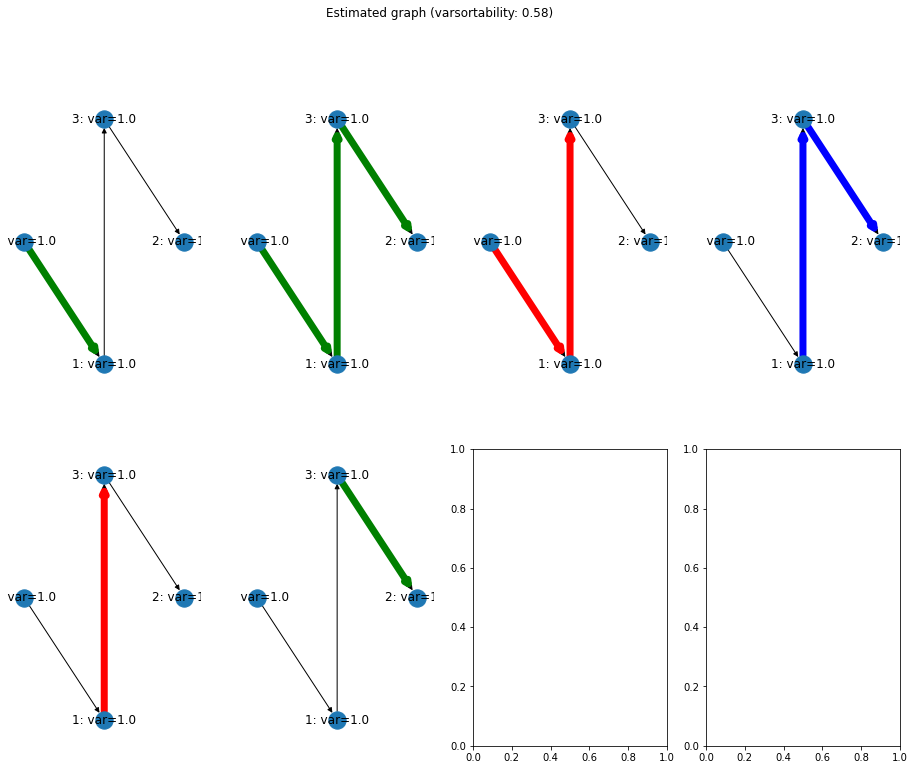

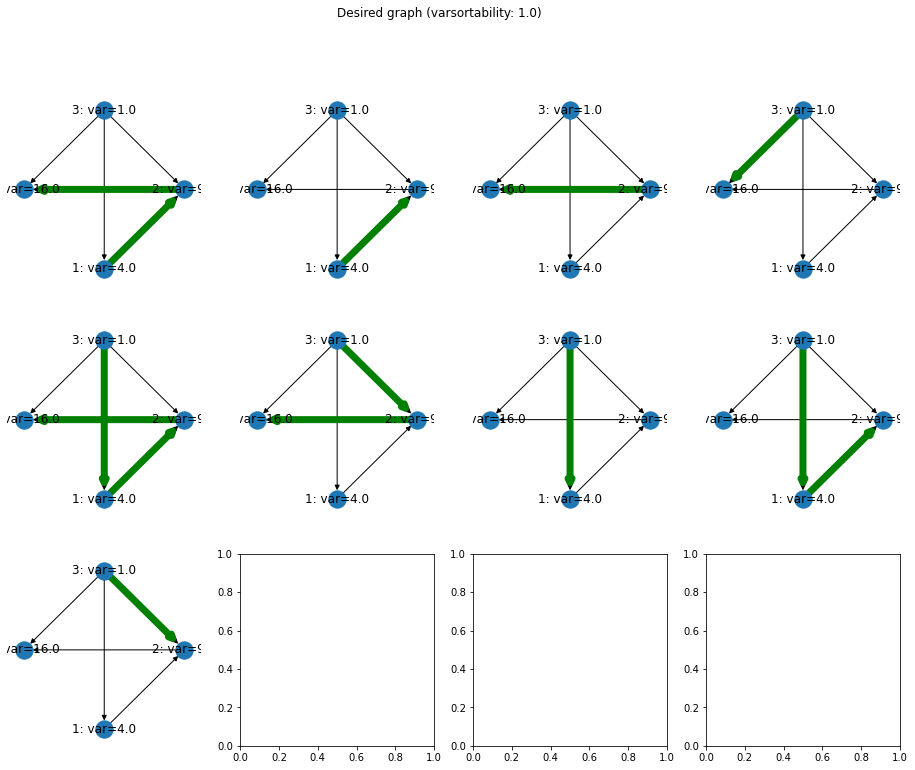

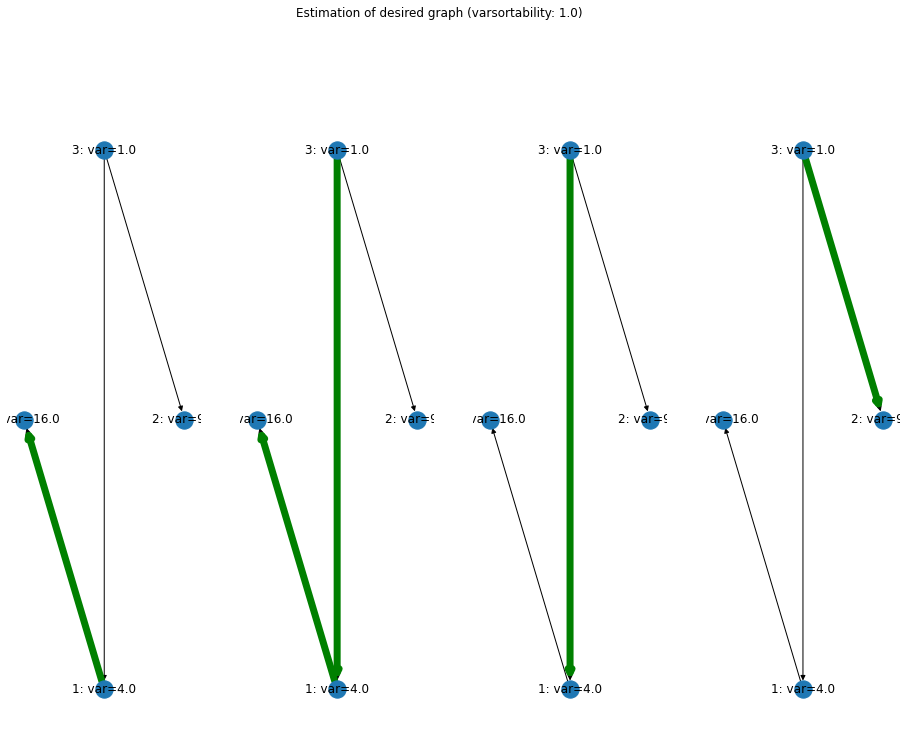

Generated graph with 4 nodes and 10.0 edges


./repos/MasterThesis/notebooks/algorithm_comparisons/algorithm_evaluation/linear.py:48: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W * 2


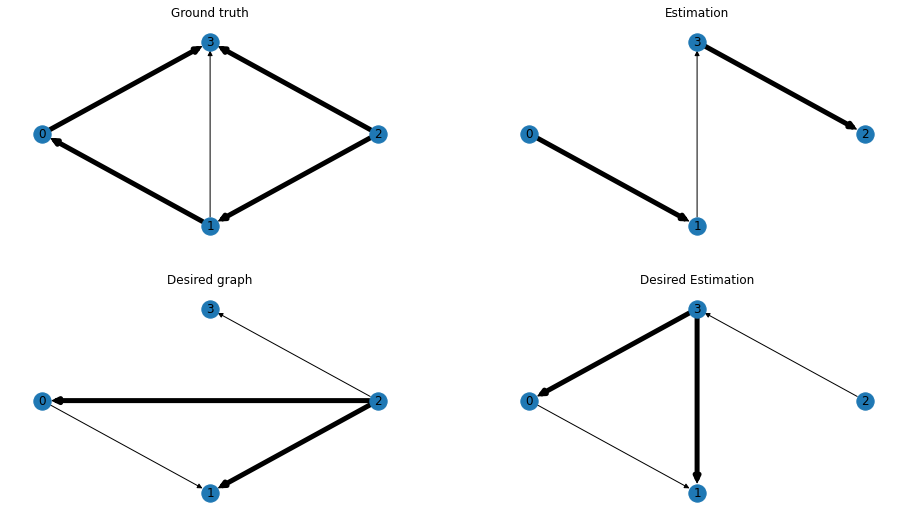

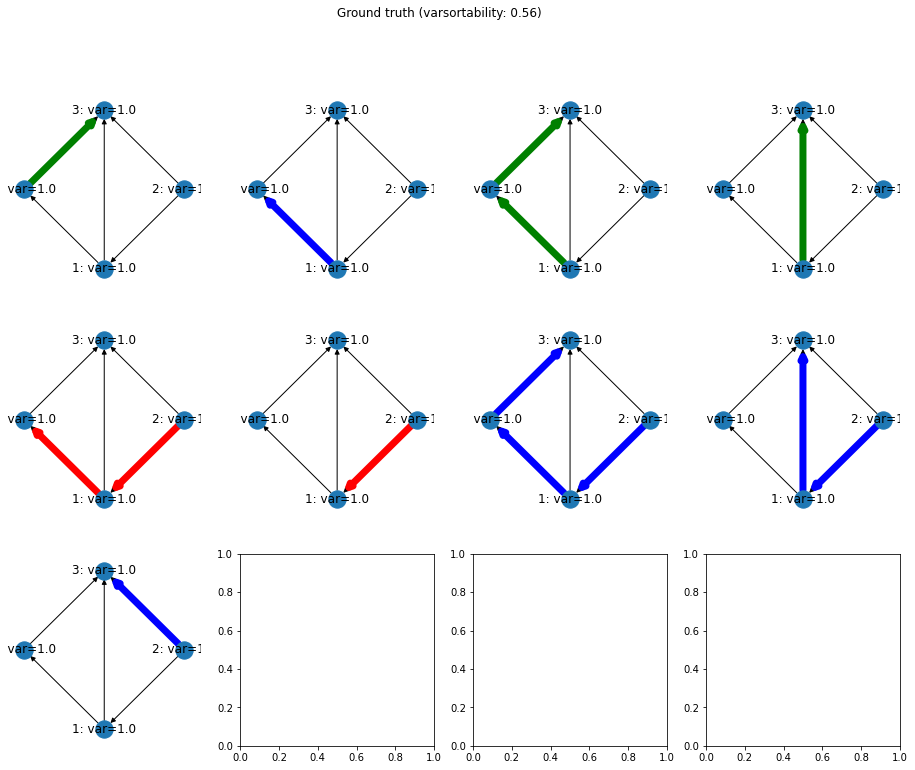

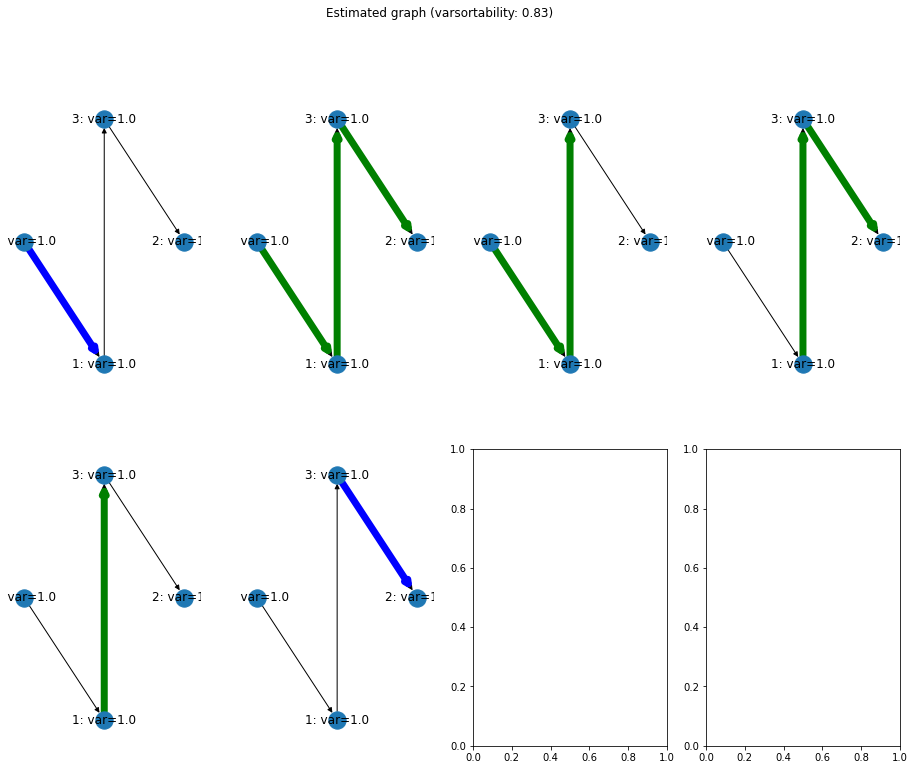

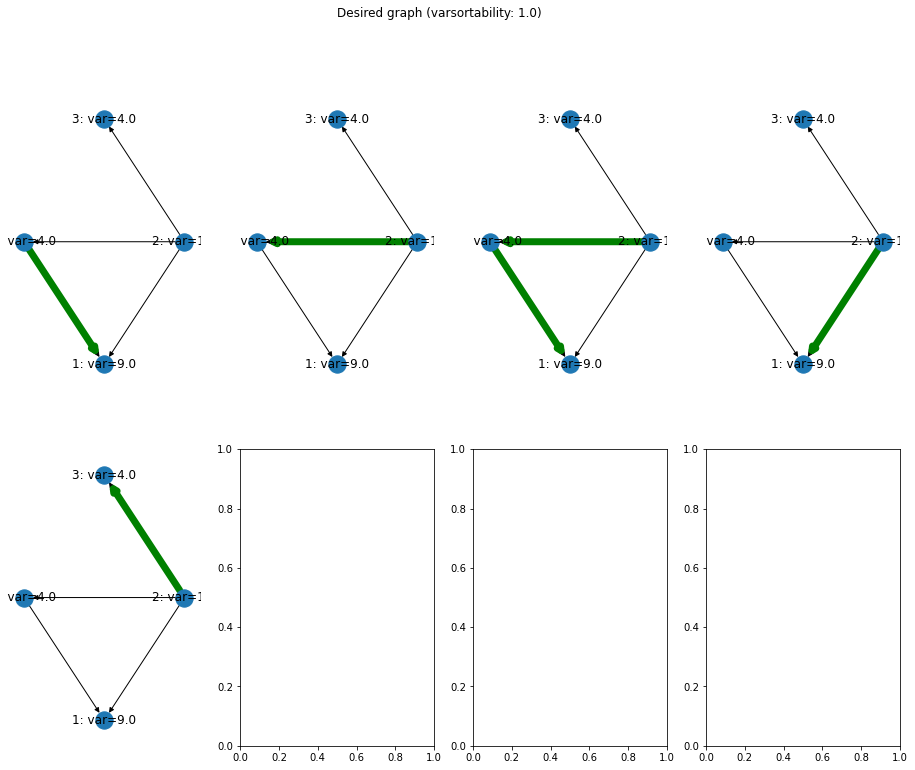

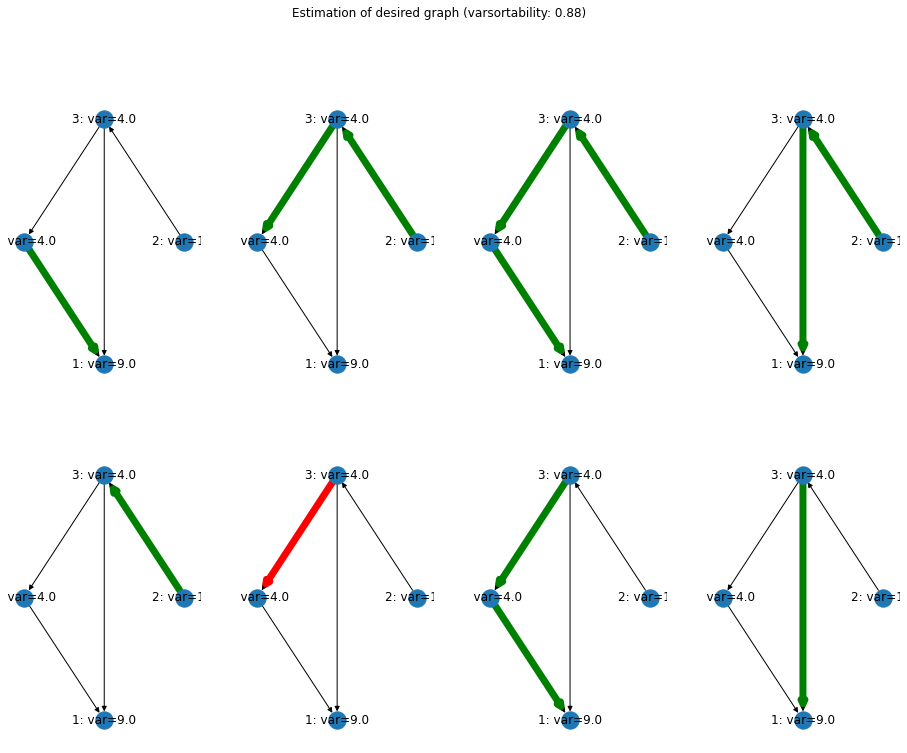

Generated graph with 4 nodes and 6.0 edges


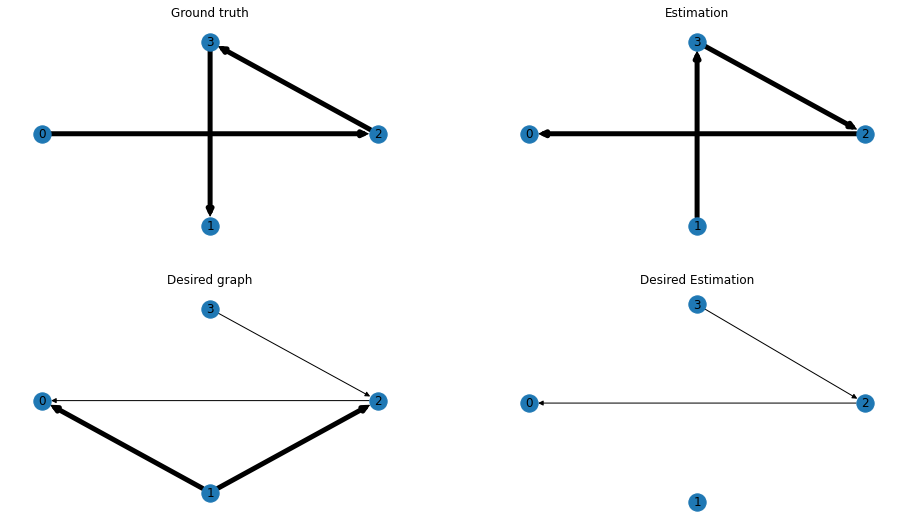

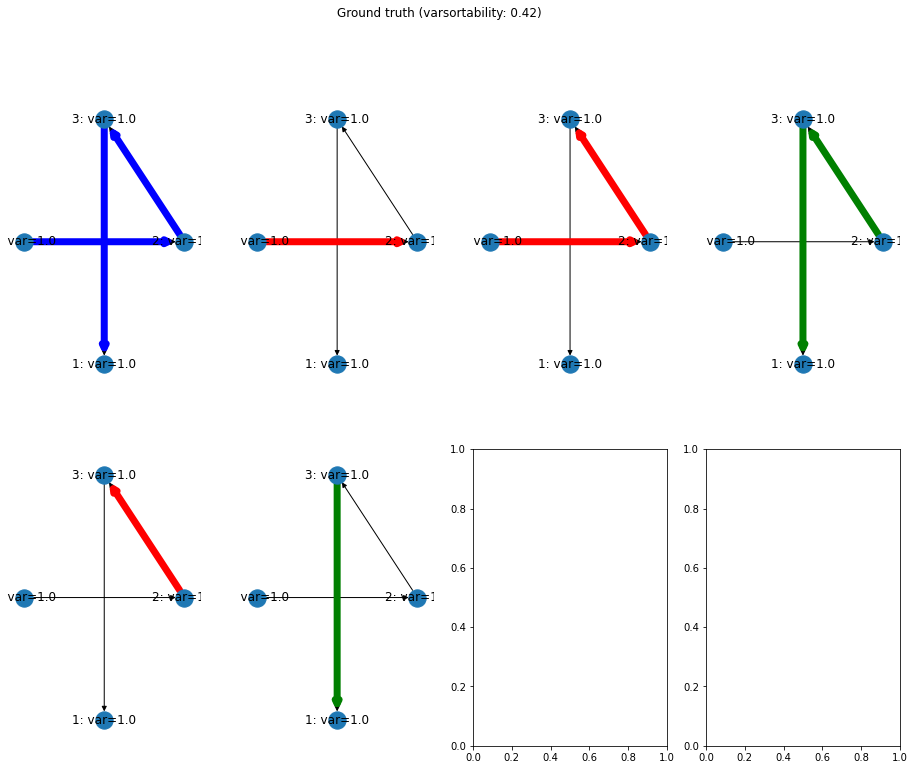

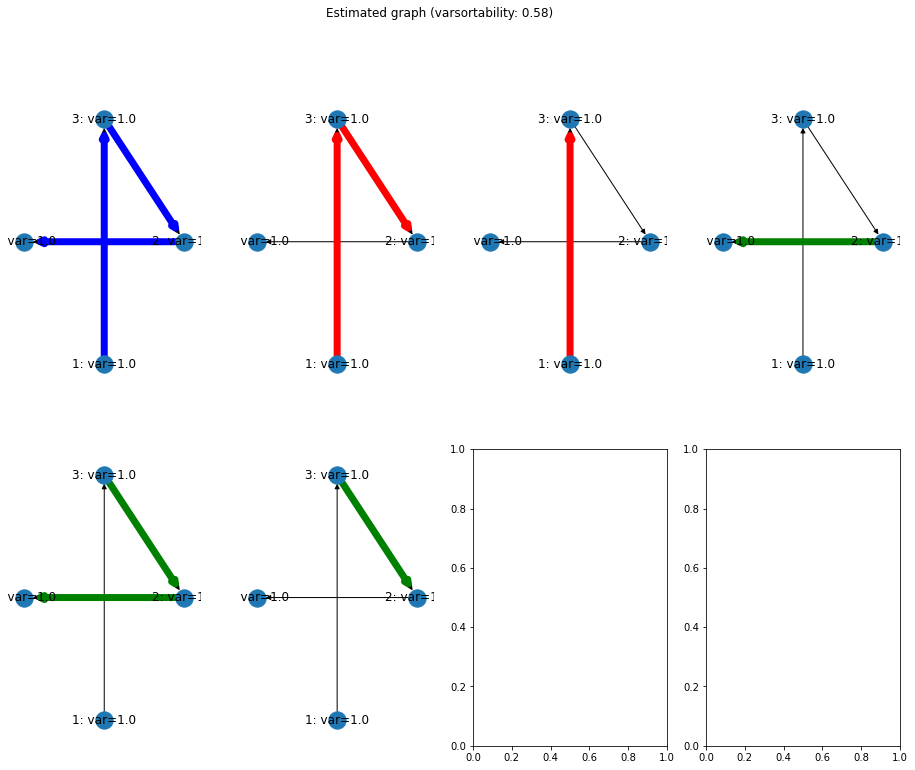

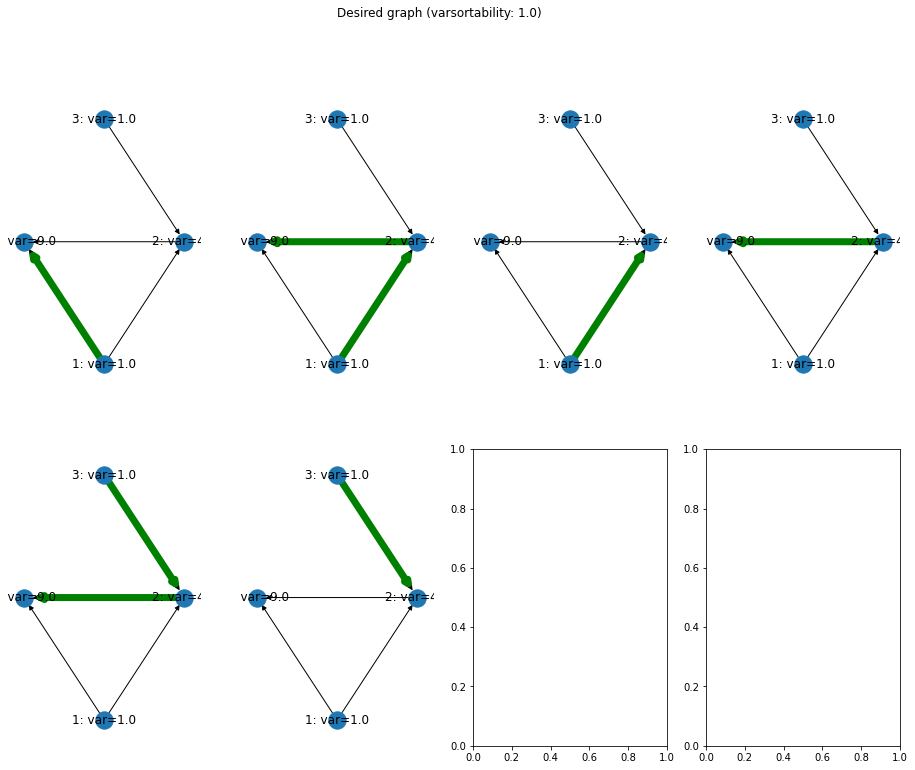

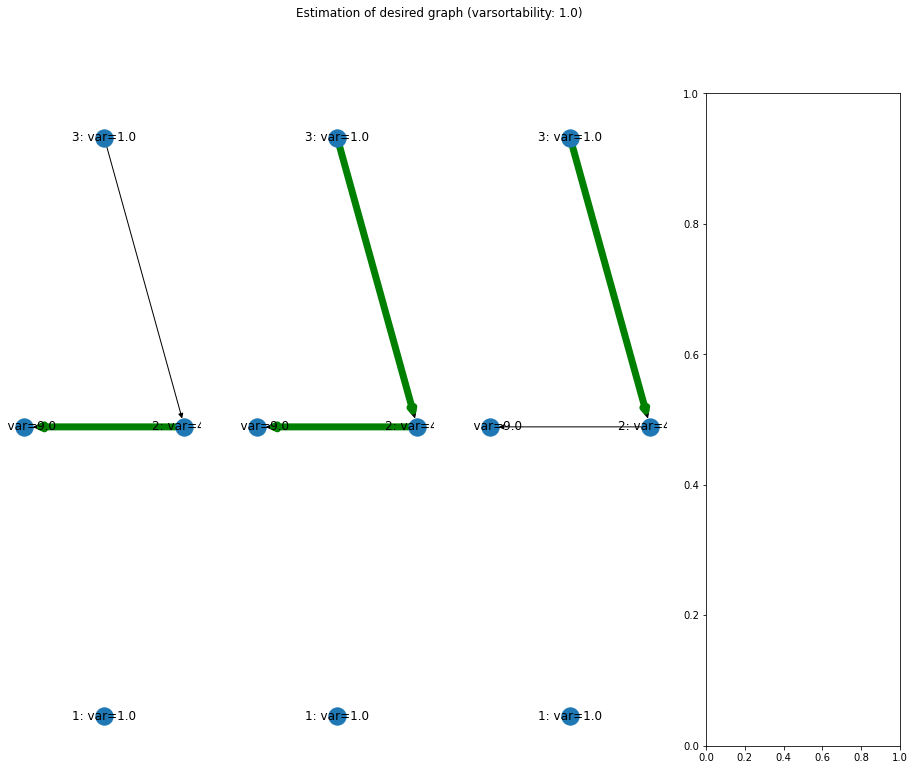

Generated graph with 4 nodes and 8.0 edges


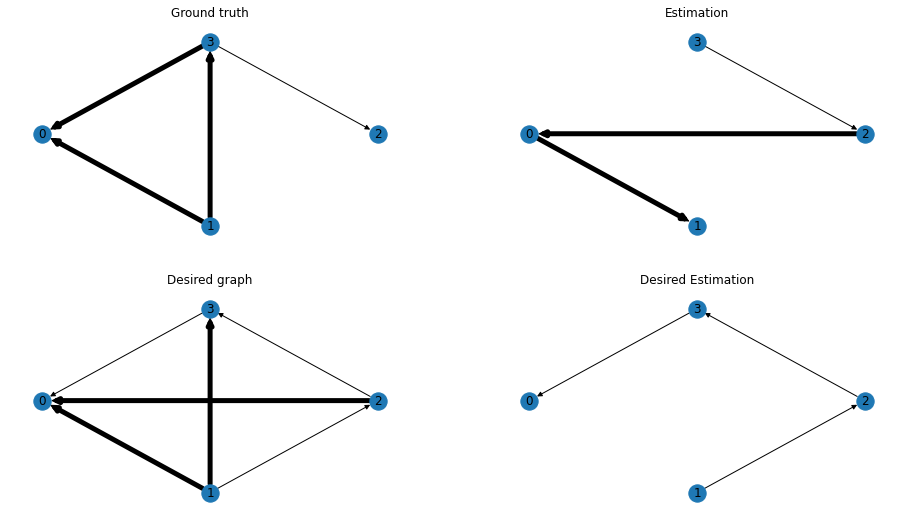

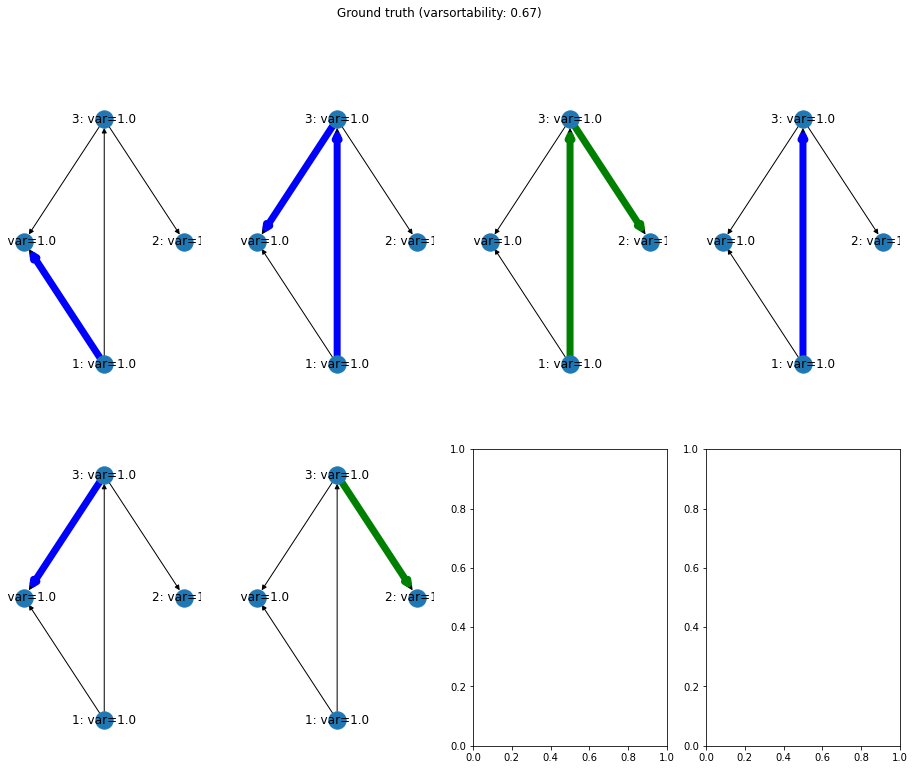

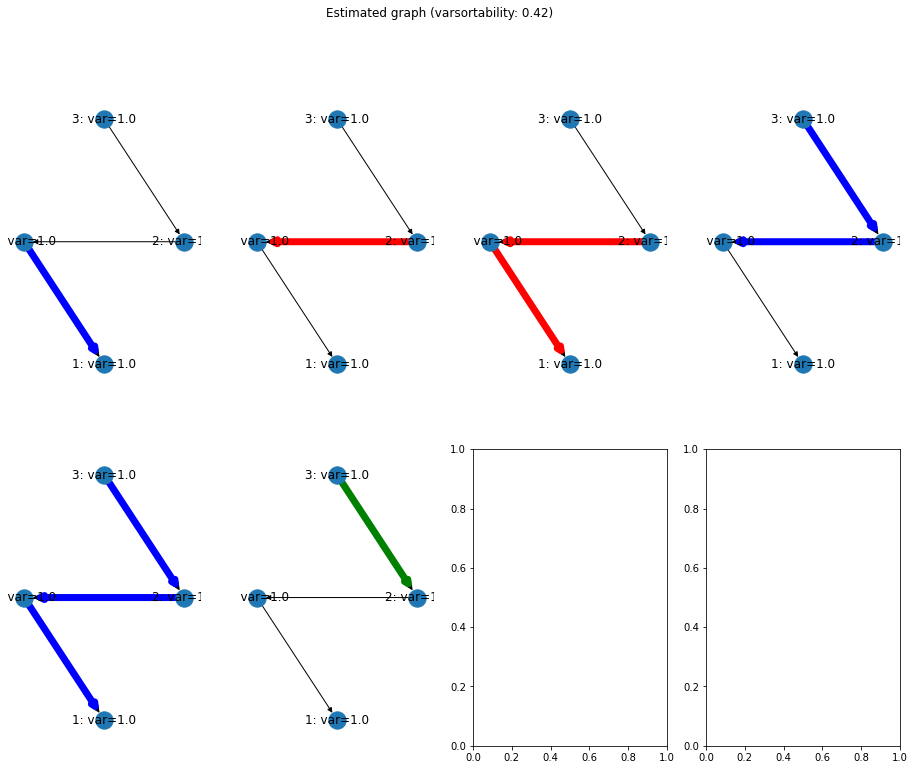

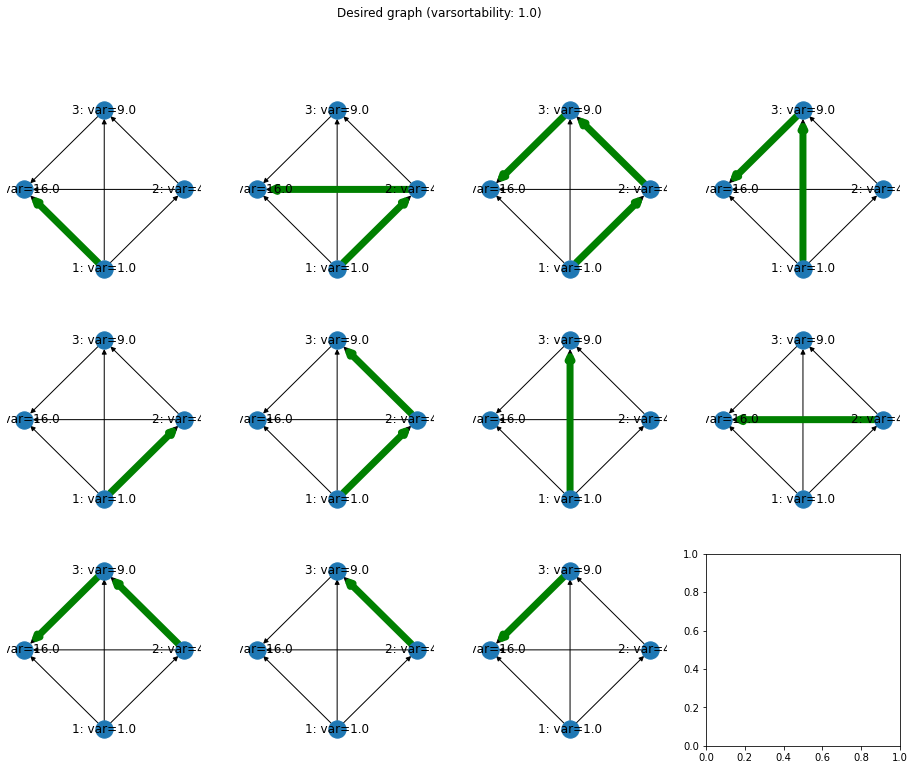

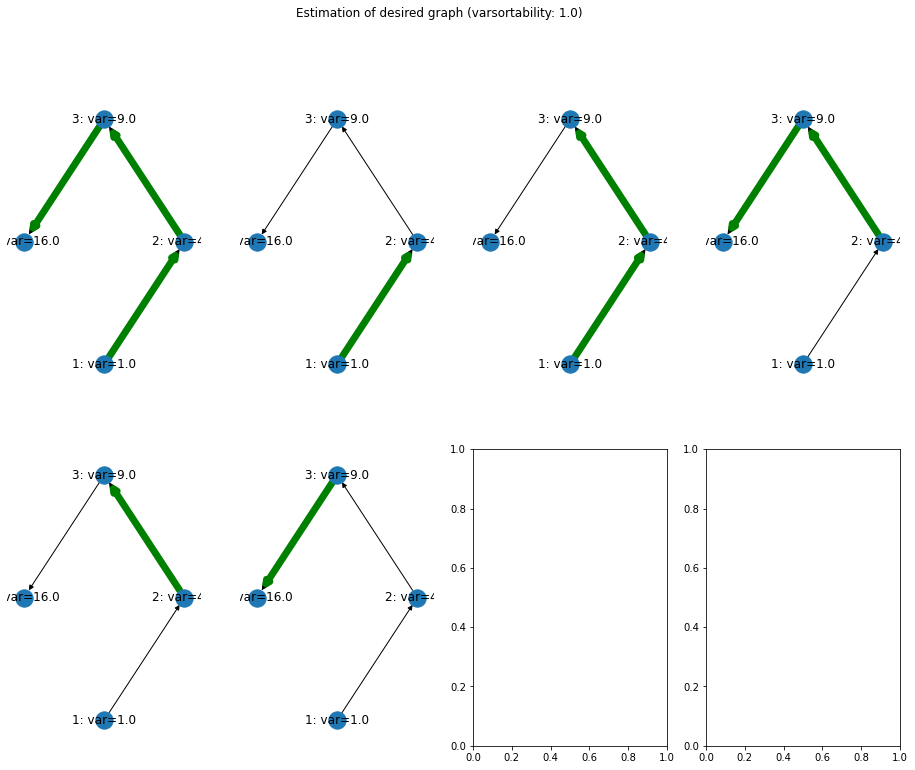

Generated graph with 4 nodes and 10.0 edges


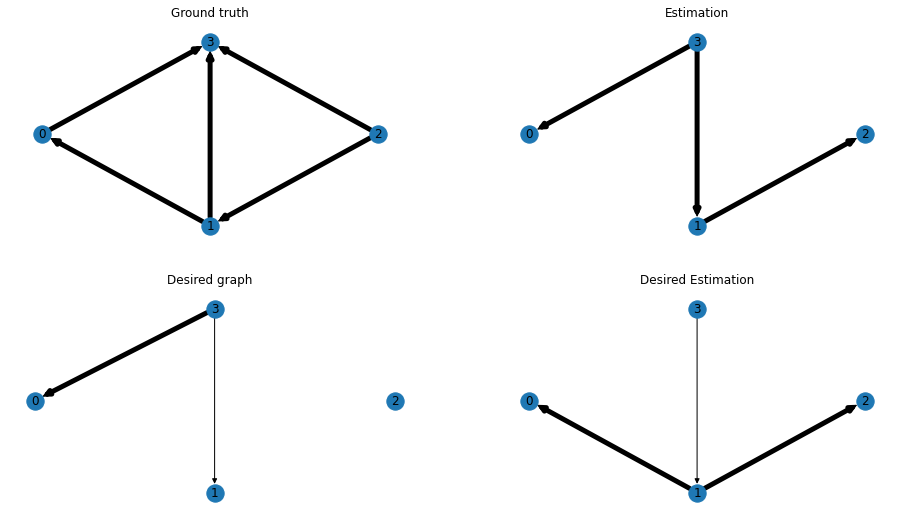

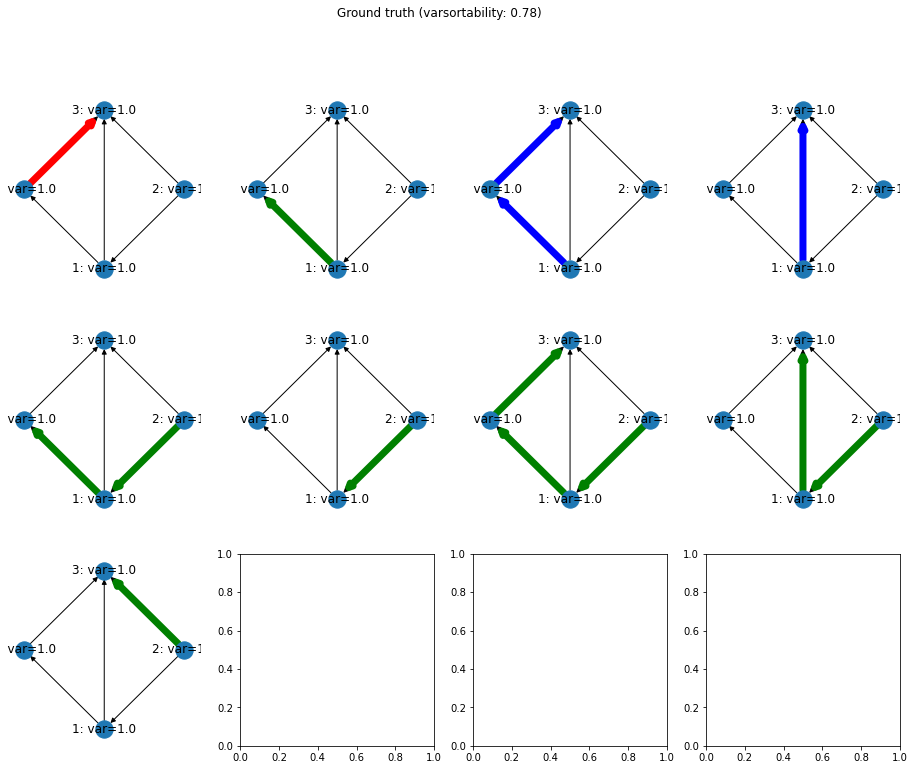

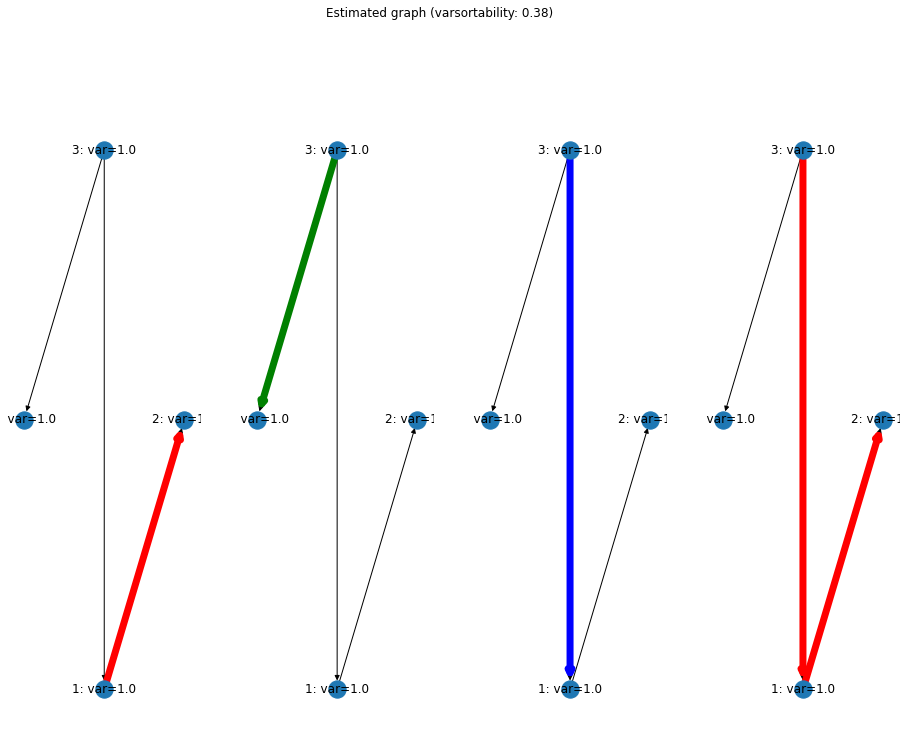

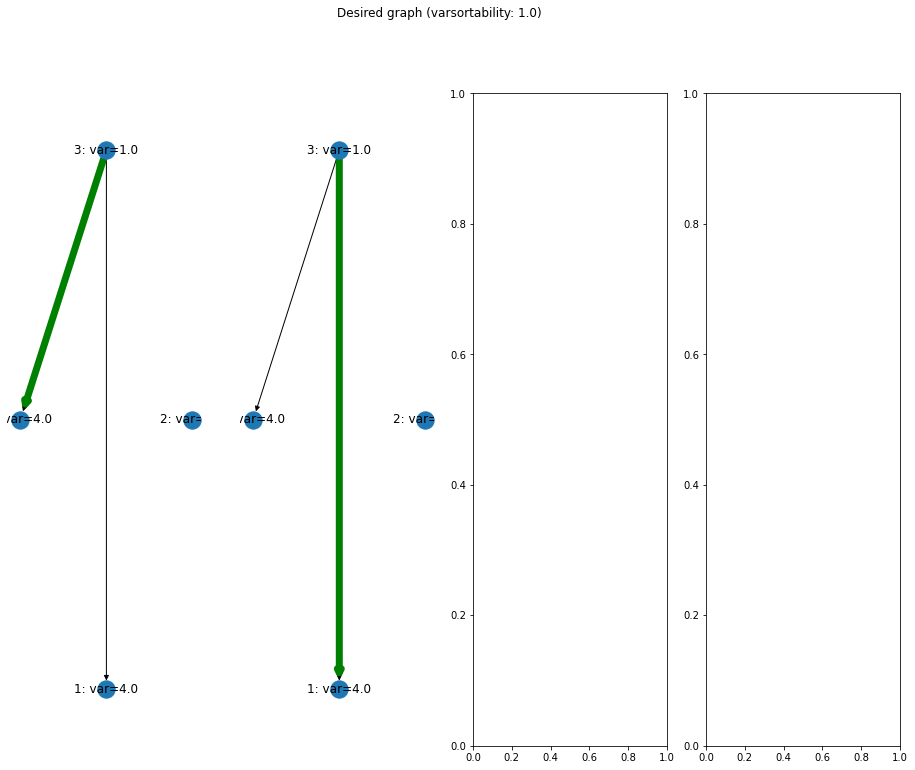

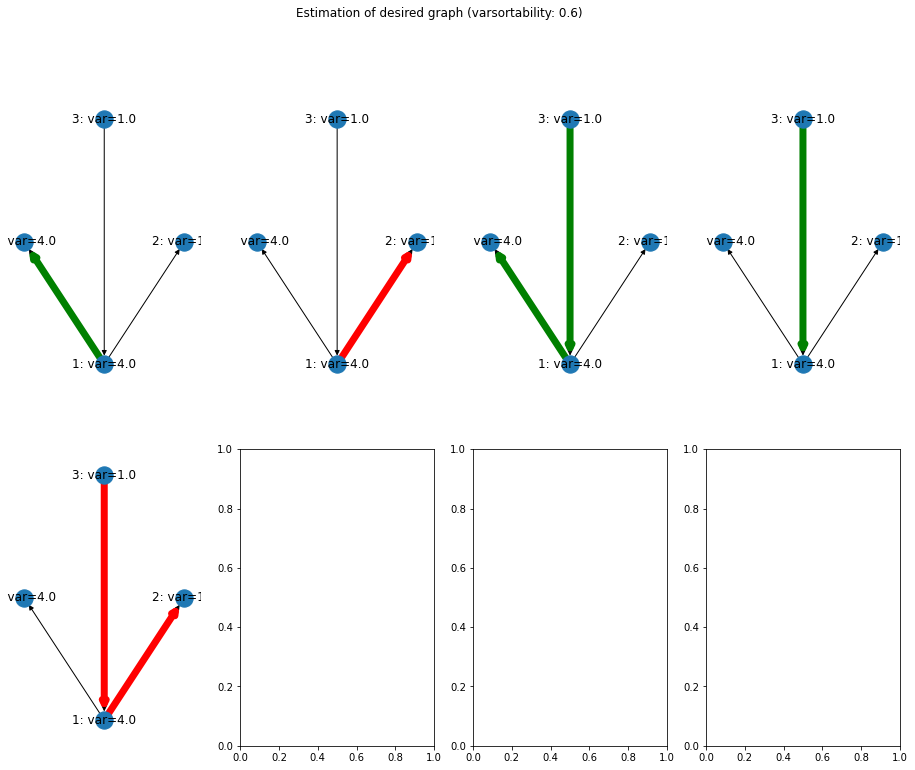

Generated graph with 4 nodes and 8.0 edges


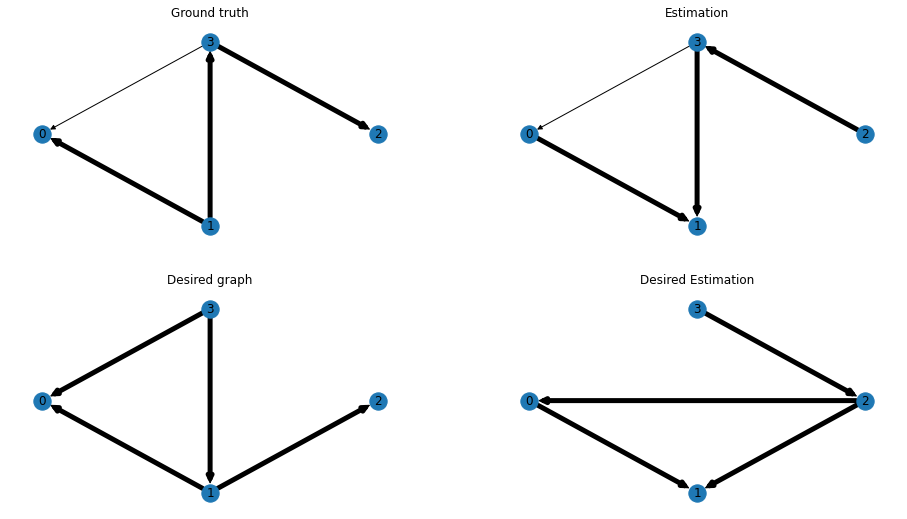

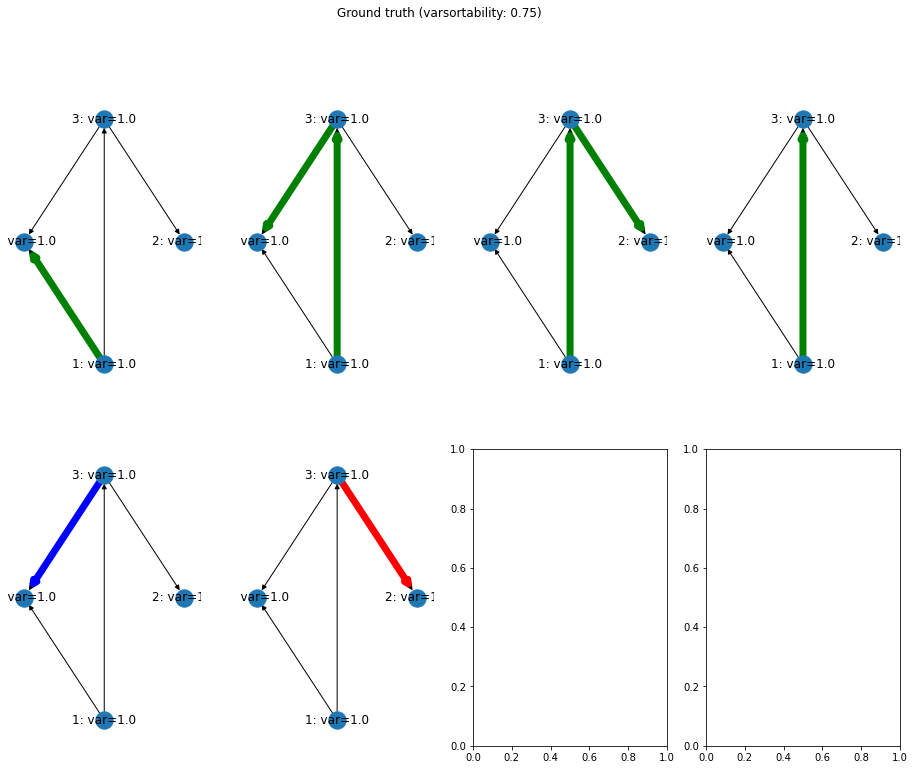

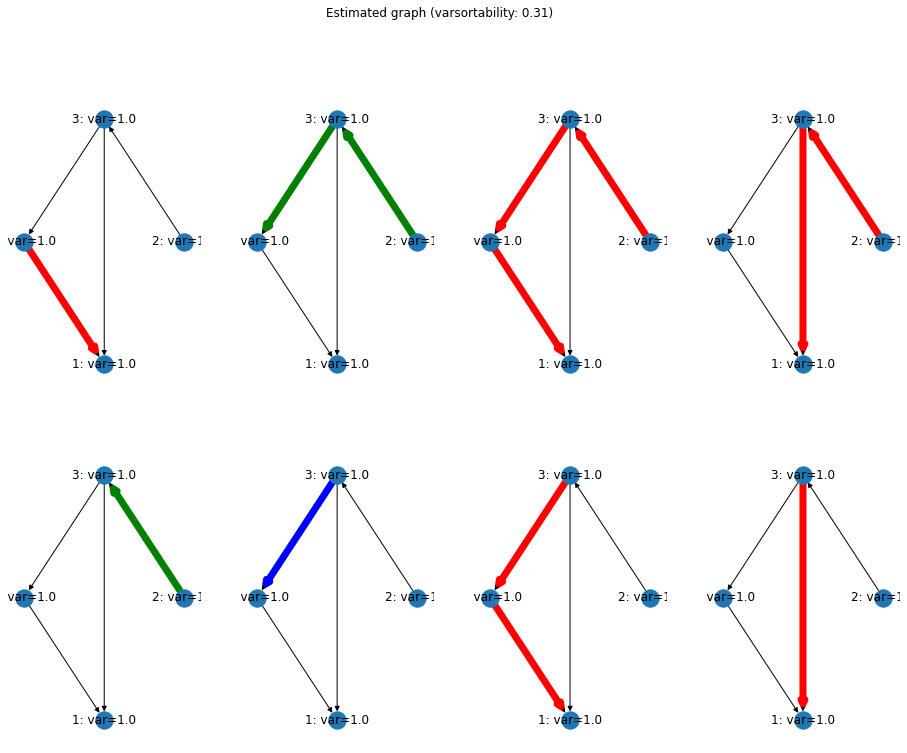

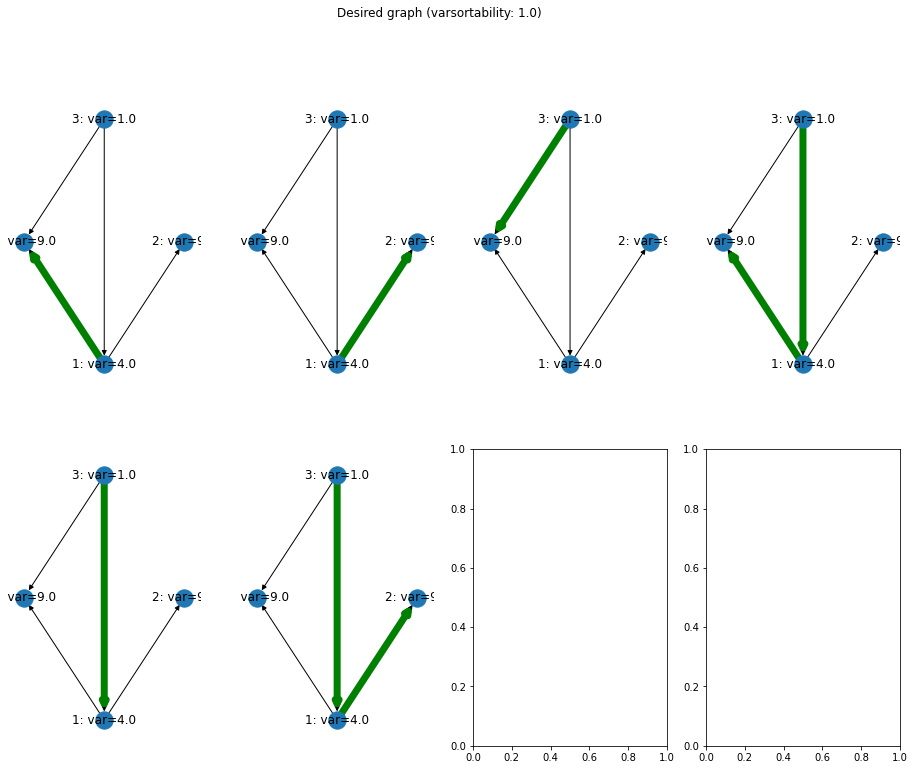

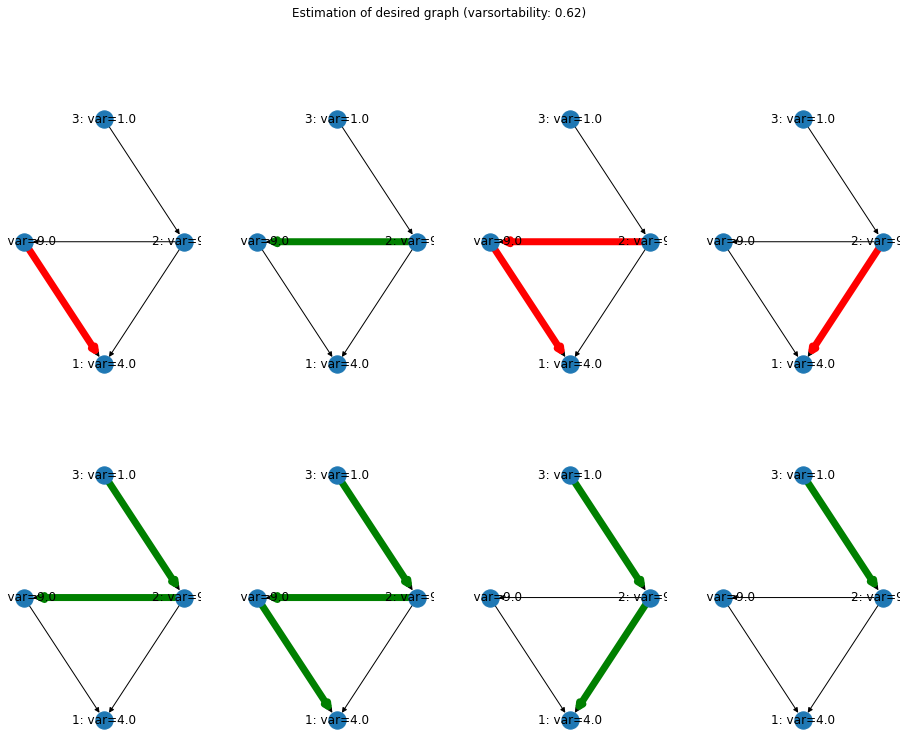

Generated graph with 4 nodes and 6.0 edges


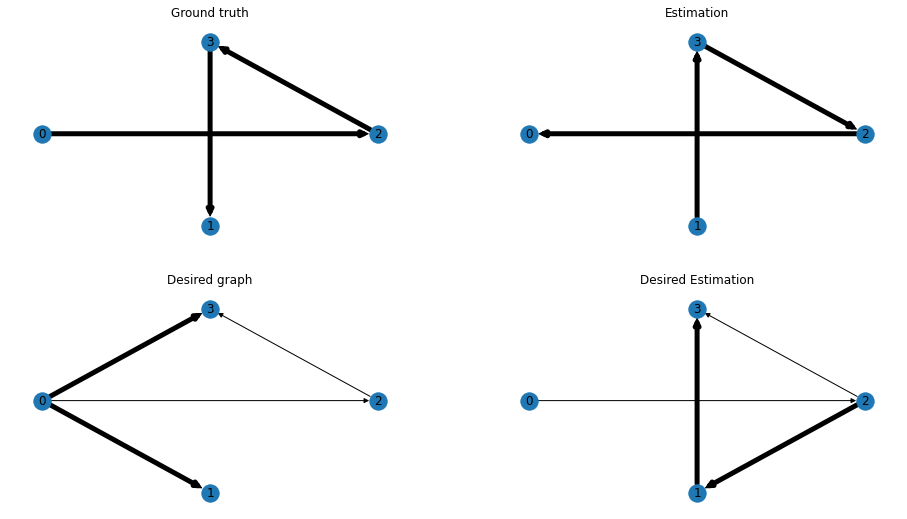

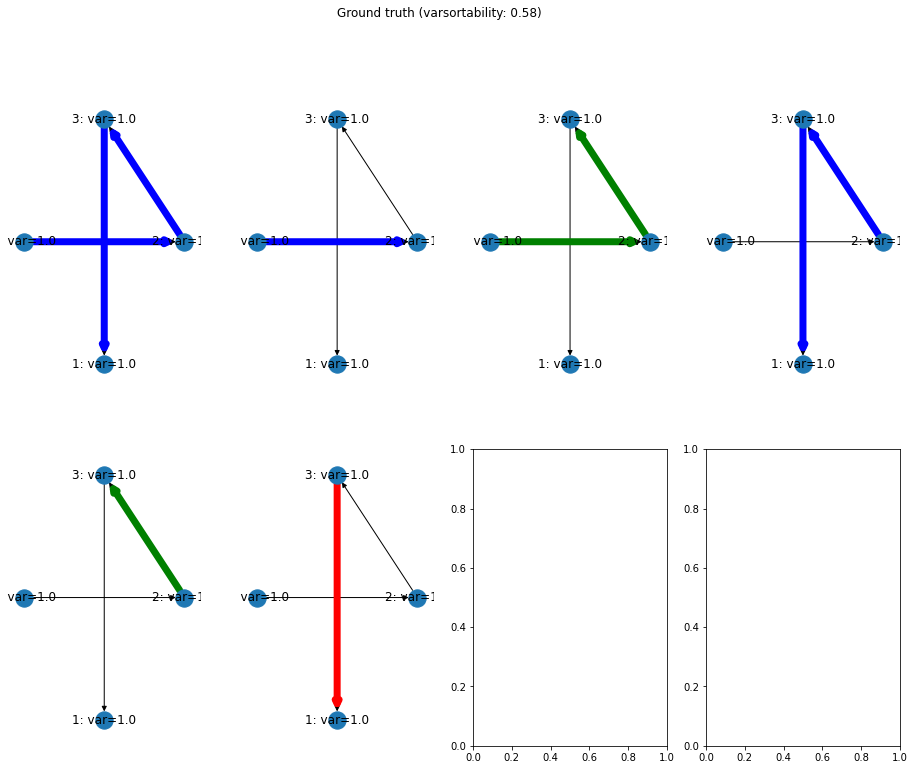

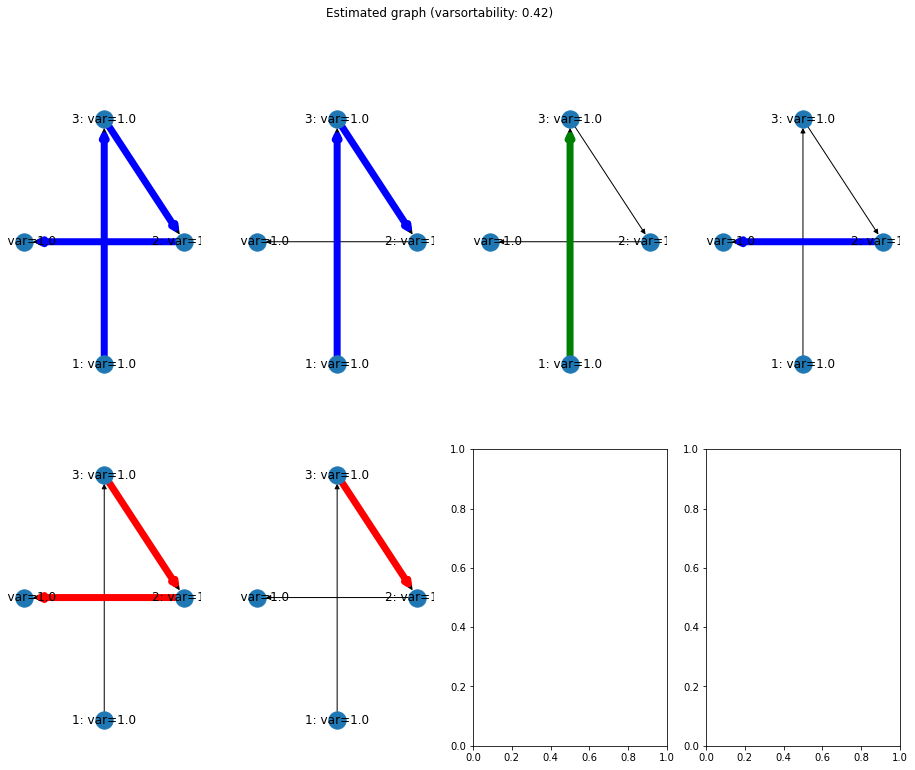

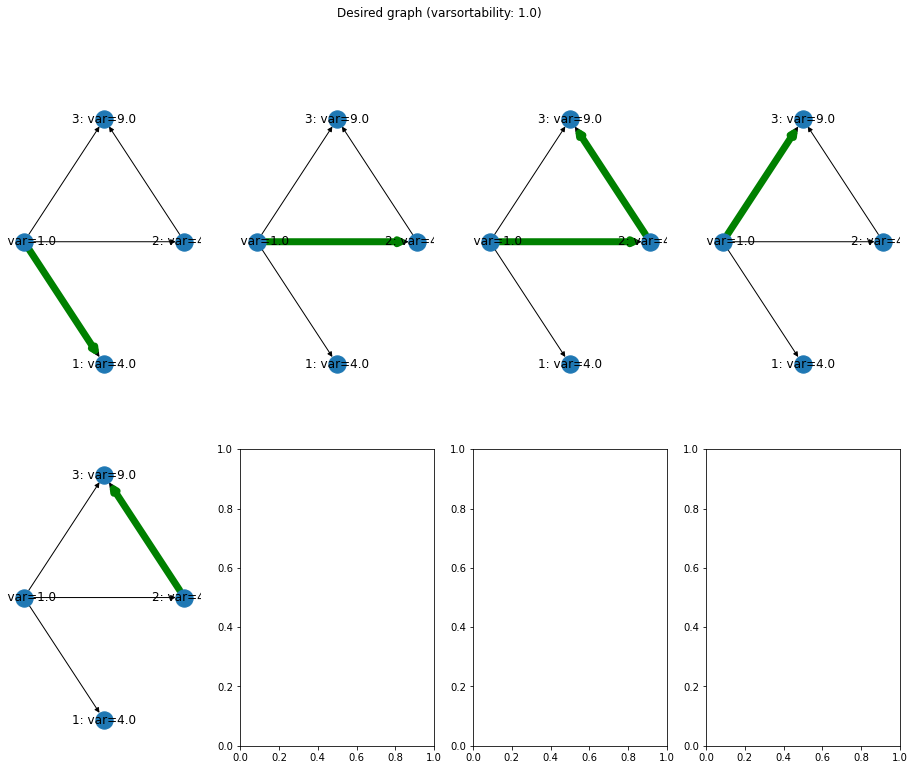

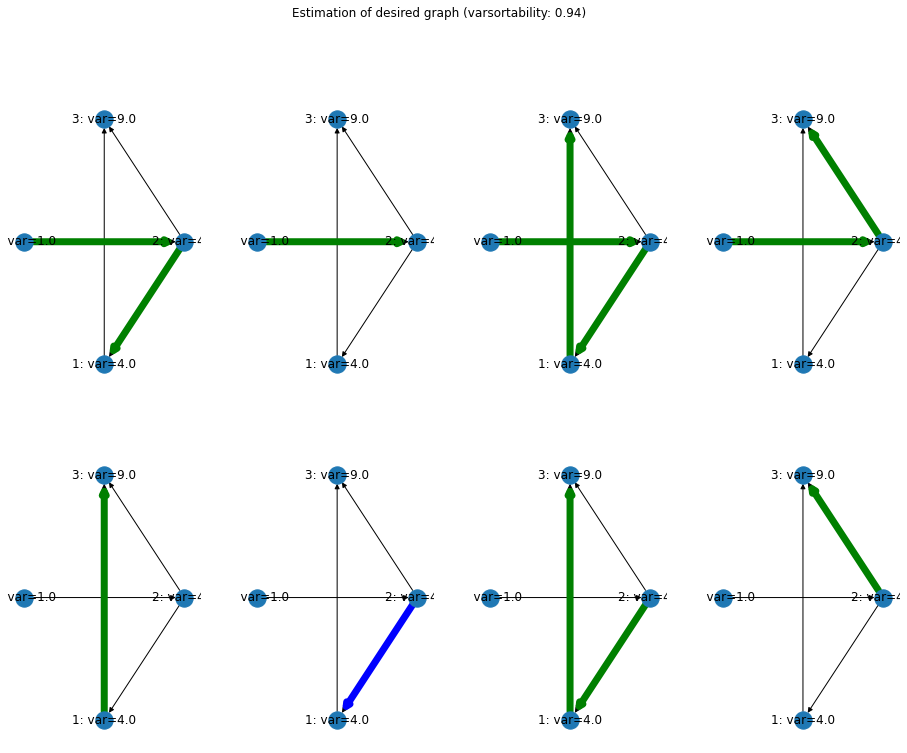

In [118]:
for idx, row in metadata_lin_gauss.iterrows():
    dataset_name = row['dataset']
    graph_name = row['graph_name']
    try:
        data = pd.read_csv(path + '/data/' + dataset_name, index_col=0)
        graph = pd.read_csv(path + 'graphs/' + graph_name, index_col=0)
        scaled_data = scale(data.to_numpy())
        edge_number = graph.to_numpy().sum()
        node_number = graph.shape[0]
        #if is_sparse(node_number, edge_number):
        #    dag_generator = DAGGenerator().generate_dag(node_number, edge_number * 2)
        #else:
        #    dag_generator = DAGGenerator().generate_dag(node_number, int(edge_number / 2))
        dag_generator = DAGGenerator().generate_dag(node_number, edge_number * 2)
        rand_dag = nx.convert_matrix.to_numpy_array(dag_generator.graph)
        pert_data = pertubate_data(rand_dag, scaled_data)
        G = nx.convert_matrix.from_numpy_array(graph.to_numpy(), create_using=nx.DiGraph)
        nt_est = nt.notears_linear(scaled_data, 0.05, 'l2')
        G_nt = nx.convert_matrix.from_numpy_array(nt_est, create_using=nx.DiGraph)
        nt_des_est = nt.notears_linear(pert_data, 0.05, 'l2')
        G_nt_des = nx.convert_matrix.from_numpy_array(nt_des_est, create_using=nx.DiGraph)
        draw_all_graphs(G, G_nt, dag_generator.graph, G_nt_des, scaled_data, pert_data)
    except FileNotFoundError:
        continue